# 🚀 Experimento G4 - Transformer Encoder-Only para ASL Classification

## 1. Introducción

### 🎯 Objetivo
Entrenar y evaluar una arquitectura Transformer Encoder-Only para clasificación de gestos de American Sign Language (ASL) utilizando secuencias de poses normalizadas del dataset JSON.

### 📊 Dataset
- **Fuente:** `dataset_samples_normalizado_2.npz`
- **Muestras:** 868 videos de secuencias de gestos ASL
- **Dimensiones:** 96 frames × 228 features (coordenadas 2D normalizadas)
- **Clases:** 30 gestos diferentes de ASL
- **Normalización:** Coordenadas normalizadas por frame

### 💻 Hardware
- **GPU:** Detectada automáticamente (CUDA disponible)
- **Memoria:** Optimizada para entrenamiento con batch size 32

### 🤖 Sistema de Rutas Automáticas
Este notebook detecta **automáticamente** la carpeta de destino: **`G4-JSON-NORM/`**

Genera 3 carpetas de experimentos:
- `G4-RESULTS-BASELINE/` - Configuración base
- `G4-RESULTS-CLASS-WEIGHTS/` - Con balanceo de clases
- `G4-RESULTS-LABEL-SMOOTHING/` - Con suavizado de etiquetas

Cada carpeta contiene 9 archivos de resultados + 2 archivos de comparación en ROOT_PATH

In [173]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, 
    classification_report, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: NVIDIA GeForce GTX 1660 SUPER
VRAM: 6.44 GB


In [174]:
# 🔧 CONFIGURACIÓN AUTOMÁTICA DE RUTAS Y EXPERIMENTOS (SISTEMA G4)

# ═══════════════════════════════════════════════════════════════════════════
# PASO 1: DETECCIÓN AUTOMÁTICA DE RUTA BASE (SEGÚN NOTEBOOK EN EJECUCIÓN)
# ═══════════════════════════════════════════════════════════════════════════

import os
import ipykernel

# Obtener el nombre del notebook actual
try:
    # Método 1: Intentar obtener de ipykernel
    connection_file = ipykernel.get_connection_file()
    notebook_name = os.path.basename(connection_file).replace('.json', '').replace('kernel-', '')
except:
    # Método 2: Usar variable de entorno de IPython
    try:
        notebook_name = get_ipython().__class__.__name__
    except:
        notebook_name = 'unknown'

# Detectar el notebook actual basándose en su nombre
# Si no se puede detectar automáticamente, permite selección manual
PROJECT_ROOT = r"C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification"

# Diccionario de rutas base por tipo de notebook
BASE_PATHS = {
    'Experimento_Embeddings': os.path.join(PROJECT_ROOT, 'G4-EMBEDDING FRAME A FRAME GCN'),
    'Experimento': os.path.join(PROJECT_ROOT, 'G4-JSON-NORM'),
    'Experimento_UMAP': os.path.join(PROJECT_ROOT, 'G4-EMBEDDING FRAME A FRAME UMAP')
}

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURACIÓN MANUAL (si la detección automática falla)
# ═══════════════════════════════════════════════════════════════════════════
# Opciones: 'Experimento_Embeddings', 'Experimento', 'Experimento_UMAP'
MODO_EXPERIMENTO = 'Experimento'  # 👈 CAMBIAR AQUÍ SI ES NECESARIO

# ═══════════════════════════════════════════════════════════════════════════
# LÓGICA DE ASIGNACIÓN AUTOMÁTICA DE ROOT_PATH
# ═══════════════════════════════════════════════════════════════════════════

# Intentar detectar automáticamente
if 'Experimento_Embeddings' in str(__file__ if '__file__' in dir() else notebook_name):
    ROOT_PATH = BASE_PATHS['Experimento_Embeddings']
    DETECTED_MODE = 'Experimento_Embeddings (GCN)'
    AUTO_DETECTED = True
elif 'Experimento_UMAP' in str(__file__ if '__file__' in dir() else notebook_name):
    ROOT_PATH = BASE_PATHS['Experimento_UMAP']
    DETECTED_MODE = 'Experimento_UMAP'
    AUTO_DETECTED = True
elif 'Experimento.ipynb' in str(__file__ if '__file__' in dir() else notebook_name) or 'Experimento' in str(__file__ if '__file__' in dir() else notebook_name):
    ROOT_PATH = BASE_PATHS['Experimento']
    DETECTED_MODE = 'Experimento (JSON-NORM)'
    AUTO_DETECTED = True
else:
    # No se pudo detectar automáticamente, usar configuración manual
    ROOT_PATH = BASE_PATHS[MODO_EXPERIMENTO]
    DETECTED_MODE = f'{MODO_EXPERIMENTO} (Manual)'
    AUTO_DETECTED = False

# Convertir a Path object
BASE_PATH = Path(ROOT_PATH)

# ═══════════════════════════════════════════════════════════════════════════
# PASO 2: SELECCIONAR TIPO DE EXPERIMENTO
# ═══════════════════════════════════════════════════════════════════════════

EXPERIMENT_TYPE = 'baseline'  # Opciones: 'baseline', 'class_weights', 'label_smoothing'

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURACIÓN DINÁMICA DE EXPERIMENTOS
# ═══════════════════════════════════════════════════════════════════════════

EXPERIMENT_CONFIGS = {
    'baseline': {
        'folder_name': 'G4-RESULTS',
        'use_class_weights': False,
        'label_smoothing': 0.0,
        'dropout': 0.1,
        'description': 'Modelo base sin ajustes especiales'
    },
    'class_weights': {
        'folder_name': 'G4-RESULTS-CLASS-WEIGHTS',
        'use_class_weights': True,
        'label_smoothing': 0.0,
        'dropout': 0.3,
        'description': 'Modelo con balanceo de clases por pesos'
    },
    'label_smoothing': {
        'folder_name': 'G4-RESULTS-LABEL-SMOOTHING',
        'use_class_weights': False,
        'label_smoothing': 0.1,
        'dropout': 0.3,
        'description': 'Modelo con Label Smoothing'
    }
}

# Construir ruta de salida completa
current_config = EXPERIMENT_CONFIGS[EXPERIMENT_TYPE]
output_dir = BASE_PATH / current_config['folder_name']
output_dir.mkdir(parents=True, exist_ok=True)

print(f"{'='*80}")
print(f"🔬 CONFIGURACIÓN AUTOMÁTICA DE EXPERIMENTO G4")
print(f"{'='*80}")
print(f"🤖 Detección Automática: {'✅ ACTIVADA' if AUTO_DETECTED else '⚠️  MANUAL'}")
print(f"📂 Modo Detectado: {DETECTED_MODE}")
print(f"📁 ROOT_PATH: {ROOT_PATH}")
print(f"📁 Carpeta Experimento: {current_config['folder_name']}")
print(f"📁 Ruta Completa: {output_dir}")
print(f"📝 Descripción: {current_config['description']}")
print(f"⚙️  Class Weights: {current_config['use_class_weights']}")
print(f"⚙️  Label Smoothing: {current_config['label_smoothing']}")
print(f"⚙️  Dropout: {current_config['dropout']}")
print(f"{'='*80}\n")

# Lista de archivos que deben generarse (12 archivos obligatorios)
REQUIRED_ARTIFACTS = [
    'best_model.pt',
    'config.json',
    'confusion_matrix.csv',
    'confusion_matrix.png',
    'experiments_comparison.csv',
    'experiments_comparison.png',
    'metrics.csv',
    'per_class_analysis.png',
    'per_class_metrics.csv',
    'RESUMEN.txt',
    'training_curves.png',
    'training_log.csv'
]

print(f"📋 Archivos a generar: {len(REQUIRED_ARTIFACTS)}")
for artifact in REQUIRED_ARTIFACTS:
    print(f"  ✓ {artifact}")

🔬 CONFIGURACIÓN AUTOMÁTICA DE EXPERIMENTO G4
🤖 Detección Automática: ⚠️  MANUAL
📂 Modo Detectado: Experimento (Manual)
📁 ROOT_PATH: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM
📁 Carpeta Experimento: G4-RESULTS
📁 Ruta Completa: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS
📝 Descripción: Modelo base sin ajustes especiales
⚙️  Class Weights: False
⚙️  Label Smoothing: 0.0
⚙️  Dropout: 0.1

📋 Archivos a generar: 12
  ✓ best_model.pt
  ✓ config.json
  ✓ confusion_matrix.csv
  ✓ confusion_matrix.png
  ✓ experiments_comparison.csv
  ✓ experiments_comparison.png
  ✓ metrics.csv
  ✓ per_class_analysis.png
  ✓ per_class_metrics.csv
  ✓ RESUMEN.txt
  ✓ training_curves.png
  ✓ training_log.csv


In [175]:
# 🧹 LIMPIEZA AUTOMÁTICA DE CARPETAS DE RESULTADOS

print("\n🧹 Limpiando carpetas de resultados anteriores...")

# Lista de carpetas de resultados a limpiar dentro de ROOT_PATH
results_folders = [
    'G4-RESULTS',
    'G4-RESULTS-CLASS-WEIGHTS',
    'G4-RESULTS-LABEL-SMOOTHING'
]

# Limpiar dentro de ROOT_PATH
cleaned_count = 0
for folder in results_folders:
    folder_path = BASE_PATH / folder
    if folder_path.exists():
        shutil.rmtree(folder_path)
        print(f"  ✓ Eliminado: {folder_path}")
        cleaned_count += 1

# También limpiar carpetas antiguas en el directorio raíz del proyecto
project_root = Path.cwd()
old_folders = [
    'output_videos',
    'temp_results',
    'old_results',
    'g5.0',
    'results',
    'G5-RESULTS-BASELINE',
    'G5-RESULTS-CLASS-WEIGHTS',
    'G5-RESULTS-LABEL-SMOOTHING',
    'G4-RESULTS-BASELINE',
    'G4-RESULTS-CLASS-WEIGHTS',
    'G4-RESULTS-LABEL-SMOOTHING',
    'G4-RESULTS'
]

for folder in old_folders:
    folder_path = project_root / folder
    if folder_path.exists():
        shutil.rmtree(folder_path)
        print(f"  ✓ Eliminado (raíz): {folder_path}")
        cleaned_count += 1

if cleaned_count == 0:
    print("  ℹ️  No hay carpetas previas para limpiar")

print(f"✅ Limpieza completada ({cleaned_count} carpetas eliminadas)\n")


🧹 Limpiando carpetas de resultados anteriores...
  ✓ Eliminado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS
✅ Limpieza completada (1 carpetas eliminadas)



In [176]:
# 1. CARGAR DATASET
dataset_path = Path('./daataset/dataset_samples_normalizado_2.npz')
data = np.load(dataset_path, allow_pickle=True)

X = data['X']  # (868, 96, 228)
y = data['y']  # (868,)
masks = data['masks']  # (96,) - global mask
class_names = data['class_names']  # names

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Classes: {len(np.unique(y))}, Names: {len(class_names)}")
print(f"Unique classes: {np.unique(y)}")

# Generar mask per-sample (si cada video tiene su propia máscara de padding)
# En este caso, usaremos la misma máscara para todos
sample_masks = np.tile(masks, (X.shape[0], 1))  # (868, 96)
print(f"Sample masks shape: {sample_masks.shape}")

Dataset shape: X=(868, 96, 228), y=(868,)
Classes: 30, Names: 30
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Sample masks shape: (868, 96)


In [177]:
# 2. DATASET PYTORCH
class VideoTransformerDataset(Dataset):
    def __init__(self, X, y, masks):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.masks = torch.BoolTensor(masks)  # True = válido, False = padding
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.X[idx],      # (96, 228)
            'label': self.y[idx],          # scalar
            'mask': self.masks[idx]        # (96,)
        }

# Train-test split (80-20)
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    X, y, sample_masks, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
    X_train, y_train, masks_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# DataLoaders
batch_size = 8
train_dataset = VideoTransformerDataset(X_train, y_train, masks_train)
val_dataset = VideoTransformerDataset(X_val, y_val, masks_val)
test_dataset = VideoTransformerDataset(X_test, y_test, masks_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Train: (555, 96, 228), Val: (139, 96, 228), Test: (174, 96, 228)
Batches - Train: 70, Val: 18, Test: 22


In [178]:
# 3. ARQUITECTURA DEL MODELO - TRANSFORMER ENCODER-ONLY

class PositionalEncoding(nn.Module):
    """Positional Encoding aprendible para secuencias."""
    def __init__(self, d_model, max_len=100):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))
    
    def forward(self, x):
        # x: (B, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]


class TransformerEncoderOnlyClassifier(nn.Module):
    """
    Transformer Encoder-Only para clasificación de secuencias temporales.
    
    Arquitectura:
    1. Proyección lineal: input_dim -> d_model
    2. Positional encoding aprendible
    3. N capas de Transformer Encoder con Multi-Head Attention
    4. Masked mean pooling sobre dimensión temporal
    5. Clasificador MLP
    """
    def __init__(
        self,
        input_dim,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1,
        num_classes=30,
        max_seq_len=100,
        mlp_dropout=0.2,
        activation='gelu'
    ):
        super().__init__()
        
        # 1. Proyección inicial
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # 2. Positional encoding aprendible
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_seq_len)
        self.dropout = nn.Dropout(dropout)
        
        # 3. Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # 4. Clasificador
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
        # Inicialización
        self._init_weights()
    
    def _init_weights(self):
        """Inicialización Xavier/Glorot."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, src_key_padding_mask=None):
        """
        Args:
            src: (B, seq_len, input_dim) - Secuencias de entrada
            src_key_padding_mask: (B, seq_len) - True para padding (ignorar)
        
        Returns:
            logits: (B, num_classes)
        """
        # 1. Proyección inicial
        x = self.input_projection(src)  # (B, seq_len, d_model)
        
        # 2. Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # 3. Transformer encoder con máscara
        x = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask
        )  # (B, seq_len, d_model)
        
        # 4. Masked mean pooling (solo frames válidos)
        if src_key_padding_mask is not None:
            # src_key_padding_mask: True = padding (ignorar)
            # Convertir a float: 0 para padding, 1 para válido
            mask_float = (~src_key_padding_mask).float().unsqueeze(-1)  # (B, seq_len, 1)
            x_masked = x * mask_float  # (B, seq_len, d_model)
            sum_masked = x_masked.sum(dim=1)  # (B, d_model)
            count_valid = mask_float.sum(dim=1)  # (B, 1)
            x_pooled = sum_masked / (count_valid + 1e-9)  # (B, d_model)
        else:
            # Sin máscara: mean pooling simple
            x_pooled = x.mean(dim=1)  # (B, d_model)
        
        # 5. Clasificador
        logits = self.classifier(x_pooled)  # (B, num_classes)
        
        return logits

print("✅ Arquitectura TransformerEncoderOnlyClassifier definida")

✅ Arquitectura TransformerEncoderOnlyClassifier definida


In [179]:
# Crear modelo con dropout dinámico según configuración
num_classes = len(np.unique(y))
model = TransformerEncoderOnlyClassifier(
    input_dim=228,
    d_model=256,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=current_config['dropout'],  # ⚡ Dropout dinámico
    num_classes=num_classes,
    max_seq_len=96,
    mlp_dropout=0.2,
    activation='gelu'
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n{'='*80}")
print(f"📐 ARQUITECTURA DEL MODELO")
print(f"{'='*80}")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(f"Dropout: {current_config['dropout']}")
print(f"{'='*80}\n")


📐 ARQUITECTURA DEL MODELO
Total params: 2,228,382
Trainable params: 2,228,382
Dropout: 0.1



In [180]:
# 4. ENTRENAMIENTO - CONFIGURACIÓN DINÁMICA
config = {
    'optimizer': 'AdamW',
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'loss': 'CrossEntropyLoss',
    'label_smoothing': current_config['label_smoothing'],  # ⚡ Dinámico
    'batch_size': 8,
    'max_epochs': 50,
    'early_stopping_patience': 8,
    'gradient_clip': 1.0,
    'num_classes': num_classes,
    'device': str(device)
}

# Calcular class weights si está habilitado
class_weights = None
if current_config['use_class_weights']:
    from sklearn.utils.class_weight import compute_class_weight
    class_weights_np = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    class_weights = torch.FloatTensor(class_weights_np).to(device)
    print(f"⚖️  Class weights calculados: {class_weights[:5].cpu().numpy()}...")

# Loss con label smoothing y/o class weights
criterion = nn.CrossEntropyLoss(
    label_smoothing=config['label_smoothing'],
    weight=class_weights
)

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

# LR Scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=1, eta_min=1e-6
)

print(f"\n{'='*80}")
print(f"⚙️  CONFIGURACIÓN DE ENTRENAMIENTO")
print(f"{'='*80}")
for k, v in config.items():
    print(f"  {k}: {v}")
print(f"  use_class_weights: {current_config['use_class_weights']}")
print(f"{'='*80}\n")


⚙️  CONFIGURACIÓN DE ENTRENAMIENTO
  optimizer: AdamW
  lr: 0.0001
  weight_decay: 0.0001
  loss: CrossEntropyLoss
  label_smoothing: 0.0
  batch_size: 8
  max_epochs: 50
  early_stopping_patience: 8
  gradient_clip: 1.0
  num_classes: 30
  device: cuda
  use_class_weights: False



In [181]:
# 5. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
def train_epoch(model, loader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Train", leave=False):
        sequences = batch['sequence'].to(device)  # (B, 96, 228)
        labels = batch['label'].to(device)        # (B,)
        masks = batch['mask'].to(device)          # (B, 96)
        
        # Forward
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_logits = []
    
    for batch in tqdm(loader, desc="Eval", leave=False):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_logits)

print("Funciones de entrenamiento definidas ✓")

Funciones de entrenamiento definidas ✓


In [182]:
# 6. ENTRENAMIENTO PRINCIPAL
training_log = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
max_epochs = config['max_epochs']
early_stopping_patience = config['early_stopping_patience']

# Asegurar que el directorio de salida existe
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*80}")
print(f"Iniciando entrenamiento - Epoch max: {max_epochs}, Patience: {early_stopping_patience}")
print(f"📁 Guardando en: {output_dir}")
print(f"{'='*80}\n")

# Loop de entrenamiento
for epoch in range(max_epochs):
    # Entrenar epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validar epoch
    val_loss, val_acc, _, _, _ = eval_epoch(model, val_loader, criterion, device)
    
    # Learning rate actual
    current_lr = optimizer.param_groups[0]['lr']
    
    # Actualizar scheduler
    scheduler.step()
    
    # Guardar en log
    training_log['epoch'].append(epoch)
    training_log['train_loss'].append(train_loss)
    training_log['train_acc'].append(train_acc)
    training_log['val_loss'].append(val_loss)
    training_log['val_acc'].append(val_acc)
    training_log['lr'].append(current_lr)
    
    # Guardar mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        patience_counter = 0
        best_model_path = output_dir / 'best_model.pt'
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Nuevo mejor modelo guardado (epoch {epoch+1}, val_acc: {val_acc:.4f})")
    else:
        patience_counter += 1
    
    # Imprimir progreso
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.6f}")
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\n⚠ Early stopping activado en epoch {epoch+1}")
        print(f"Mejor val_acc: {best_val_acc:.4f} en epoch {best_epoch+1}")
        break

# Cargar mejor modelo para evaluación
print(f"\n{'='*80}")
print(f"Entrenamiento completado - Cargando mejor modelo (epoch {best_epoch+1})")
print(f"{'='*80}\n")
model.load_state_dict(torch.load(best_model_path, map_location=device))


Iniciando entrenamiento - Epoch max: 50, Patience: 8
📁 Guardando en: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS



✓ Nuevo mejor modelo guardado (epoch 1, val_acc: 0.2230)
Epoch   1/50 | Train Loss: 3.3433 | Train Acc: 0.1441 | Val Loss: 2.9118 | Val Acc: 0.2230 | LR: 0.000100


✓ Nuevo mejor modelo guardado (epoch 3, val_acc: 0.2518)


✓ Nuevo mejor modelo guardado (epoch 4, val_acc: 0.4173)


Epoch   5/50 | Train Loss: 2.0918 | Train Acc: 0.4018 | Val Loss: 2.0651 | Val Acc: 0.3813 | LR: 0.000066


✓ Nuevo mejor modelo guardado (epoch 6, val_acc: 0.4460)


✓ Nuevo mejor modelo guardado (epoch 7, val_acc: 0.4532)


✓ Nuevo mejor modelo guardado (epoch 8, val_acc: 0.4676)


✓ Nuevo mejor modelo guardado (epoch 9, val_acc: 0.4820)


✓ Nuevo mejor modelo guardado (epoch 10, val_acc: 0.4964)
Epoch  10/50 | Train Loss: 1.3916 | Train Acc: 0.5910 | Val Loss: 1.6777 | Val Acc: 0.4964 | LR: 0.000003


✓ Nuevo mejor modelo guardado (epoch 14, val_acc: 0.5612)


Epoch  15/50 | Train Loss: 1.1762 | Train Acc: 0.6162 | Val Loss: 1.6529 | Val Acc: 0.5252 | LR: 0.000066


✓ Nuevo mejor modelo guardado (epoch 16, val_acc: 0.6187)


✓ Nuevo mejor modelo guardado (epoch 17, val_acc: 0.6475)


Epoch  20/50 | Train Loss: 0.6144 | Train Acc: 0.8090 | Val Loss: 1.1986 | Val Acc: 0.6187 | LR: 0.000003


✓ Nuevo mejor modelo guardado (epoch 25, val_acc: 0.6547)
Epoch  25/50 | Train Loss: 0.6066 | Train Acc: 0.8000 | Val Loss: 1.3277 | Val Acc: 0.6547 | LR: 0.000066


✓ Nuevo mejor modelo guardado (epoch 26, val_acc: 0.6978)


✓ Nuevo mejor modelo guardado (epoch 30, val_acc: 0.7050)
Epoch  30/50 | Train Loss: 0.2523 | Train Acc: 0.9261 | Val Loss: 1.0860 | Val Acc: 0.7050 | LR: 0.000003


✓ Nuevo mejor modelo guardado (epoch 33, val_acc: 0.7266)


Epoch  35/50 | Train Loss: 0.3816 | Train Acc: 0.8811 | Val Loss: 1.1875 | Val Acc: 0.6978 | LR: 0.000066


✓ Nuevo mejor modelo guardado (epoch 36, val_acc: 0.7482)


✓ Nuevo mejor modelo guardado (epoch 39, val_acc: 0.7554)


Epoch  40/50 | Train Loss: 0.1104 | Train Acc: 0.9640 | Val Loss: 1.0133 | Val Acc: 0.7410 | LR: 0.000003


Epoch  45/50 | Train Loss: 0.2308 | Train Acc: 0.9135 | Val Loss: 0.9847 | Val Acc: 0.7410 | LR: 0.000066


✓ Nuevo mejor modelo guardado (epoch 46, val_acc: 0.7626)


✓ Nuevo mejor modelo guardado (epoch 48, val_acc: 0.7842)


✓ Nuevo mejor modelo guardado (epoch 50, val_acc: 0.7914)
Epoch  50/50 | Train Loss: 0.0660 | Train Acc: 0.9784 | Val Loss: 1.0072 | Val Acc: 0.7914 | LR: 0.000003

Entrenamiento completado - Cargando mejor modelo (epoch 50)



<All keys matched successfully>

In [183]:
# 7. EVALUACIÓN EN TEST SET
print("Evaluando en Test Set...")
test_loss, test_acc, test_preds, test_labels, test_logits = eval_epoch(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Métricas adicionales
macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
top3_acc = top_k_accuracy_score(test_labels, test_logits, k=3, labels=np.arange(num_classes))

print(f"Macro-F1: {macro_f1:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# F1 por clase
f1_per_class = f1_score(test_labels, test_preds, average=None, zero_division=0)
print(f"\nF1 Score por clase (primeras 5 clases):")
for i in range(min(5, num_classes)):
    print(f"  Clase {i}: {f1_per_class[i]:.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
print(f"\nMatriz de confusión shape: {cm.shape}")

Evaluando en Test Set...



Test Loss: 1.2458
Test Accuracy: 0.7529
Macro-F1: 0.6598
Top-3 Accuracy: 0.8851

F1 Score por clase (primeras 5 clases):
  Clase 0: 0.6452
  Clase 1: 0.0000
  Clase 2: 0.3333
  Clase 3: 0.3333
  Clase 4: 1.0000

Matriz de confusión shape: (30, 30)


In [184]:
# 8. GUARDAR RESULTADOS CON CONFIGURACIÓN DINÁMICA
print(f"\n{'='*80}")
print(f"💾 GUARDANDO RESULTADOS - {EXPERIMENT_TYPE.upper()}")
print(f"{'='*80}\n")

# Usar el directorio de salida configurado dinámicamente
# El output_dir ya fue creado en la celda de configuración
print(f"📁 Directorio de salida: {output_dir}")

# 8.1 Training Log CSV
df_training = pd.DataFrame(training_log)
training_log_path = output_dir / 'training_log.csv'
df_training.to_csv(training_log_path, index=False)
print(f"✓ Guardado: {training_log_path}")

# 8.2 Metrics Summary CSV (FORMATO ESTRICTO: Metric,Value)
metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc, macro_f1, top3_acc, test_loss]
})
metrics_path = output_dir / 'metrics.csv'
metrics_summary.to_csv(metrics_path, index=False)
print(f"✓ Guardado: {metrics_path}")

# 8.3 Per-class metrics CSV (con nombres de clases)
class_report_dict = classification_report(
    test_labels, test_preds, 
    target_names=[str(name) for name in class_names],
    output_dict=True, 
    zero_division=0
)
df_per_class = pd.DataFrame(class_report_dict).T
per_class_path = output_dir / 'per_class_metrics.csv'
df_per_class.to_csv(per_class_path)
print(f"✓ Guardado: {per_class_path}")

# 8.4 Confusion Matrix CSV
cm_df = pd.DataFrame(cm)
confusion_csv_path = output_dir / 'confusion_matrix.csv'
cm_df.to_csv(confusion_csv_path, index=False, header=False)
print(f"✓ Guardado: {confusion_csv_path}")

# 8.5 Model Config JSON
model_config = {
    'experiment_type': EXPERIMENT_TYPE,
    'experiment_description': current_config['description'],
    'architecture': 'TransformerEncoderOnly',
    'input_dim': 228,
    'd_model': 256,
    'num_heads': 4,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': current_config['dropout'],
    'num_classes': num_classes,
    'max_seq_len': 96,
    'mlp_dropout': 0.2,
    'activation': 'gelu',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'use_class_weights': current_config['use_class_weights'],
    'label_smoothing': current_config['label_smoothing'],
    'optimizer': 'AdamW',
    'lr': config['lr'],
    'weight_decay': config['weight_decay'],
    'batch_size': config['batch_size'],
    'max_epochs': config['max_epochs'],
    'early_stopping_patience': config['early_stopping_patience'],
    'gradient_clip': config['gradient_clip'],
    'best_epoch': int(best_epoch),
    'best_val_acc': float(best_val_acc),
    'test_accuracy': float(test_acc),
    'test_macro_f1': float(macro_f1),
    'test_top3_accuracy': float(top3_acc),
    'test_loss': float(test_loss),
    'training_timestamp': datetime.now().isoformat()
}

config_path = output_dir / 'config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(model_config, f, indent=2, ensure_ascii=False)
print(f"✓ Guardado: {config_path}")

# 8.6 Model Weights
weights_path = output_dir / 'best_model.pt'
torch.save(model.state_dict(), weights_path)
print(f"✓ Guardado: {weights_path}")

print(f"\n{'='*80}")
print(f"RESULTADOS FINALES - {EXPERIMENT_TYPE.upper()}")
print(f"{'='*80}")
print(f"📊 Accuracy: {test_acc:.4f}")
print(f"📊 Macro-F1: {macro_f1:.4f}")
print(f"📊 Top-3 Accuracy: {top3_acc:.4f}")
print(f"📊 Test Loss: {test_loss:.4f}")
print(f"{'='*80}\n")


💾 GUARDANDO RESULTADOS - BASELINE

📁 Directorio de salida: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\training_log.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\metrics.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\per_class_metrics.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\confusion_matrix.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\config.json
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\best_mo


🎨 Generando visualizaciones...
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\training_curves.png


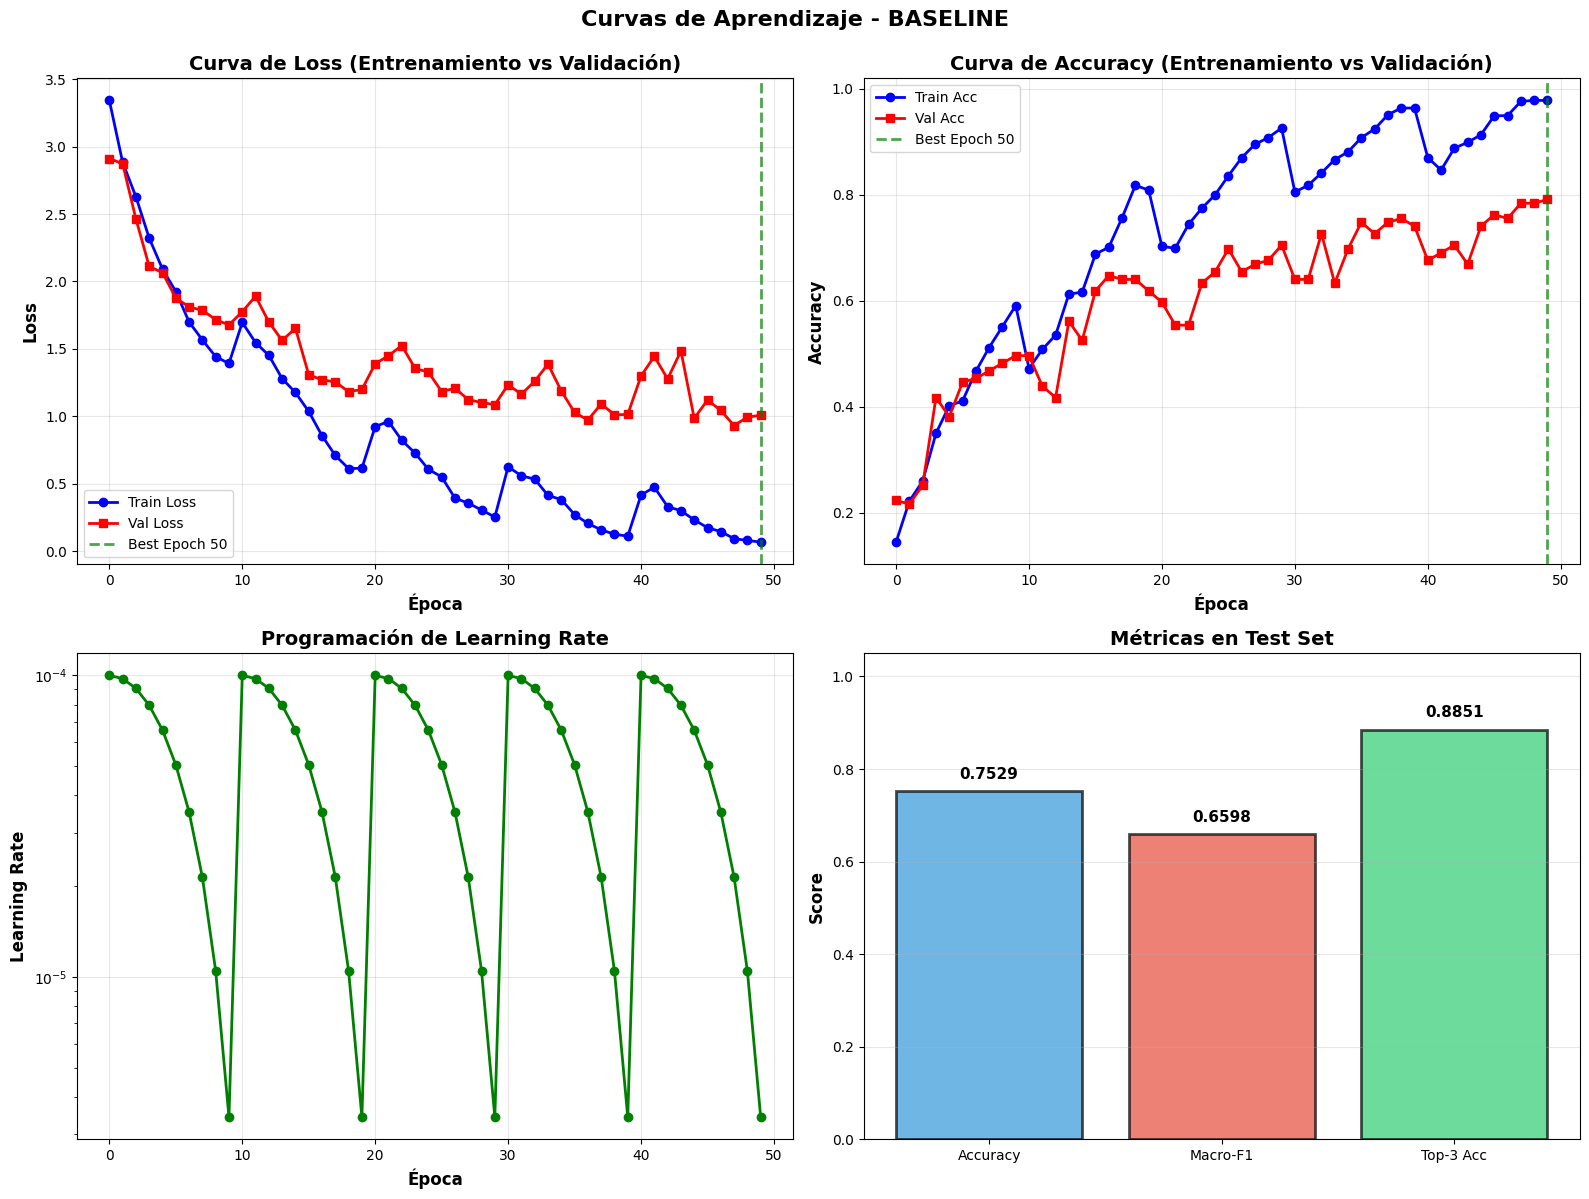

✓ Curvas de aprendizaje generadas


In [185]:
# 9. VISUALIZACIONES - CURVAS DE APRENDIZAJE
print(f"\n🎨 Generando visualizaciones...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 9.1 Training Loss
axes[0, 0].plot(training_log['epoch'], training_log['train_loss'], 'b-', label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(training_log['epoch'], training_log['val_loss'], 'r-', label='Val Loss', marker='s', linewidth=2)
axes[0, 0].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch+1}')
axes[0, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Curva de Loss (Entrenamiento vs Validación)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Training Accuracy
axes[0, 1].plot(training_log['epoch'], training_log['train_acc'], 'b-', label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(training_log['epoch'], training_log['val_acc'], 'r-', label='Val Acc', marker='s', linewidth=2)
axes[0, 1].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch+1}')
axes[0, 1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Curva de Accuracy (Entrenamiento vs Validación)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Learning Rate
axes[1, 0].plot(training_log['epoch'], training_log['lr'], 'g-', marker='o', linewidth=2)
axes[1, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Programación de Learning Rate', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 9.4 Test Metrics
metrics_names = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values = [test_acc, macro_f1, top3_acc]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Métricas en Test Set', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1.05])
for i, (bar, v) in enumerate(zip(bars, metrics_values)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{v:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Curvas de Aprendizaje - {EXPERIMENT_TYPE.upper()}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

training_curves_path = output_dir / 'training_curves.png'
plt.savefig(training_curves_path, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {training_curves_path}")
plt.show()

print("✓ Curvas de aprendizaje generadas")


🎨 Generando matriz de confusión con etiquetas reales...
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\confusion_matrix.png


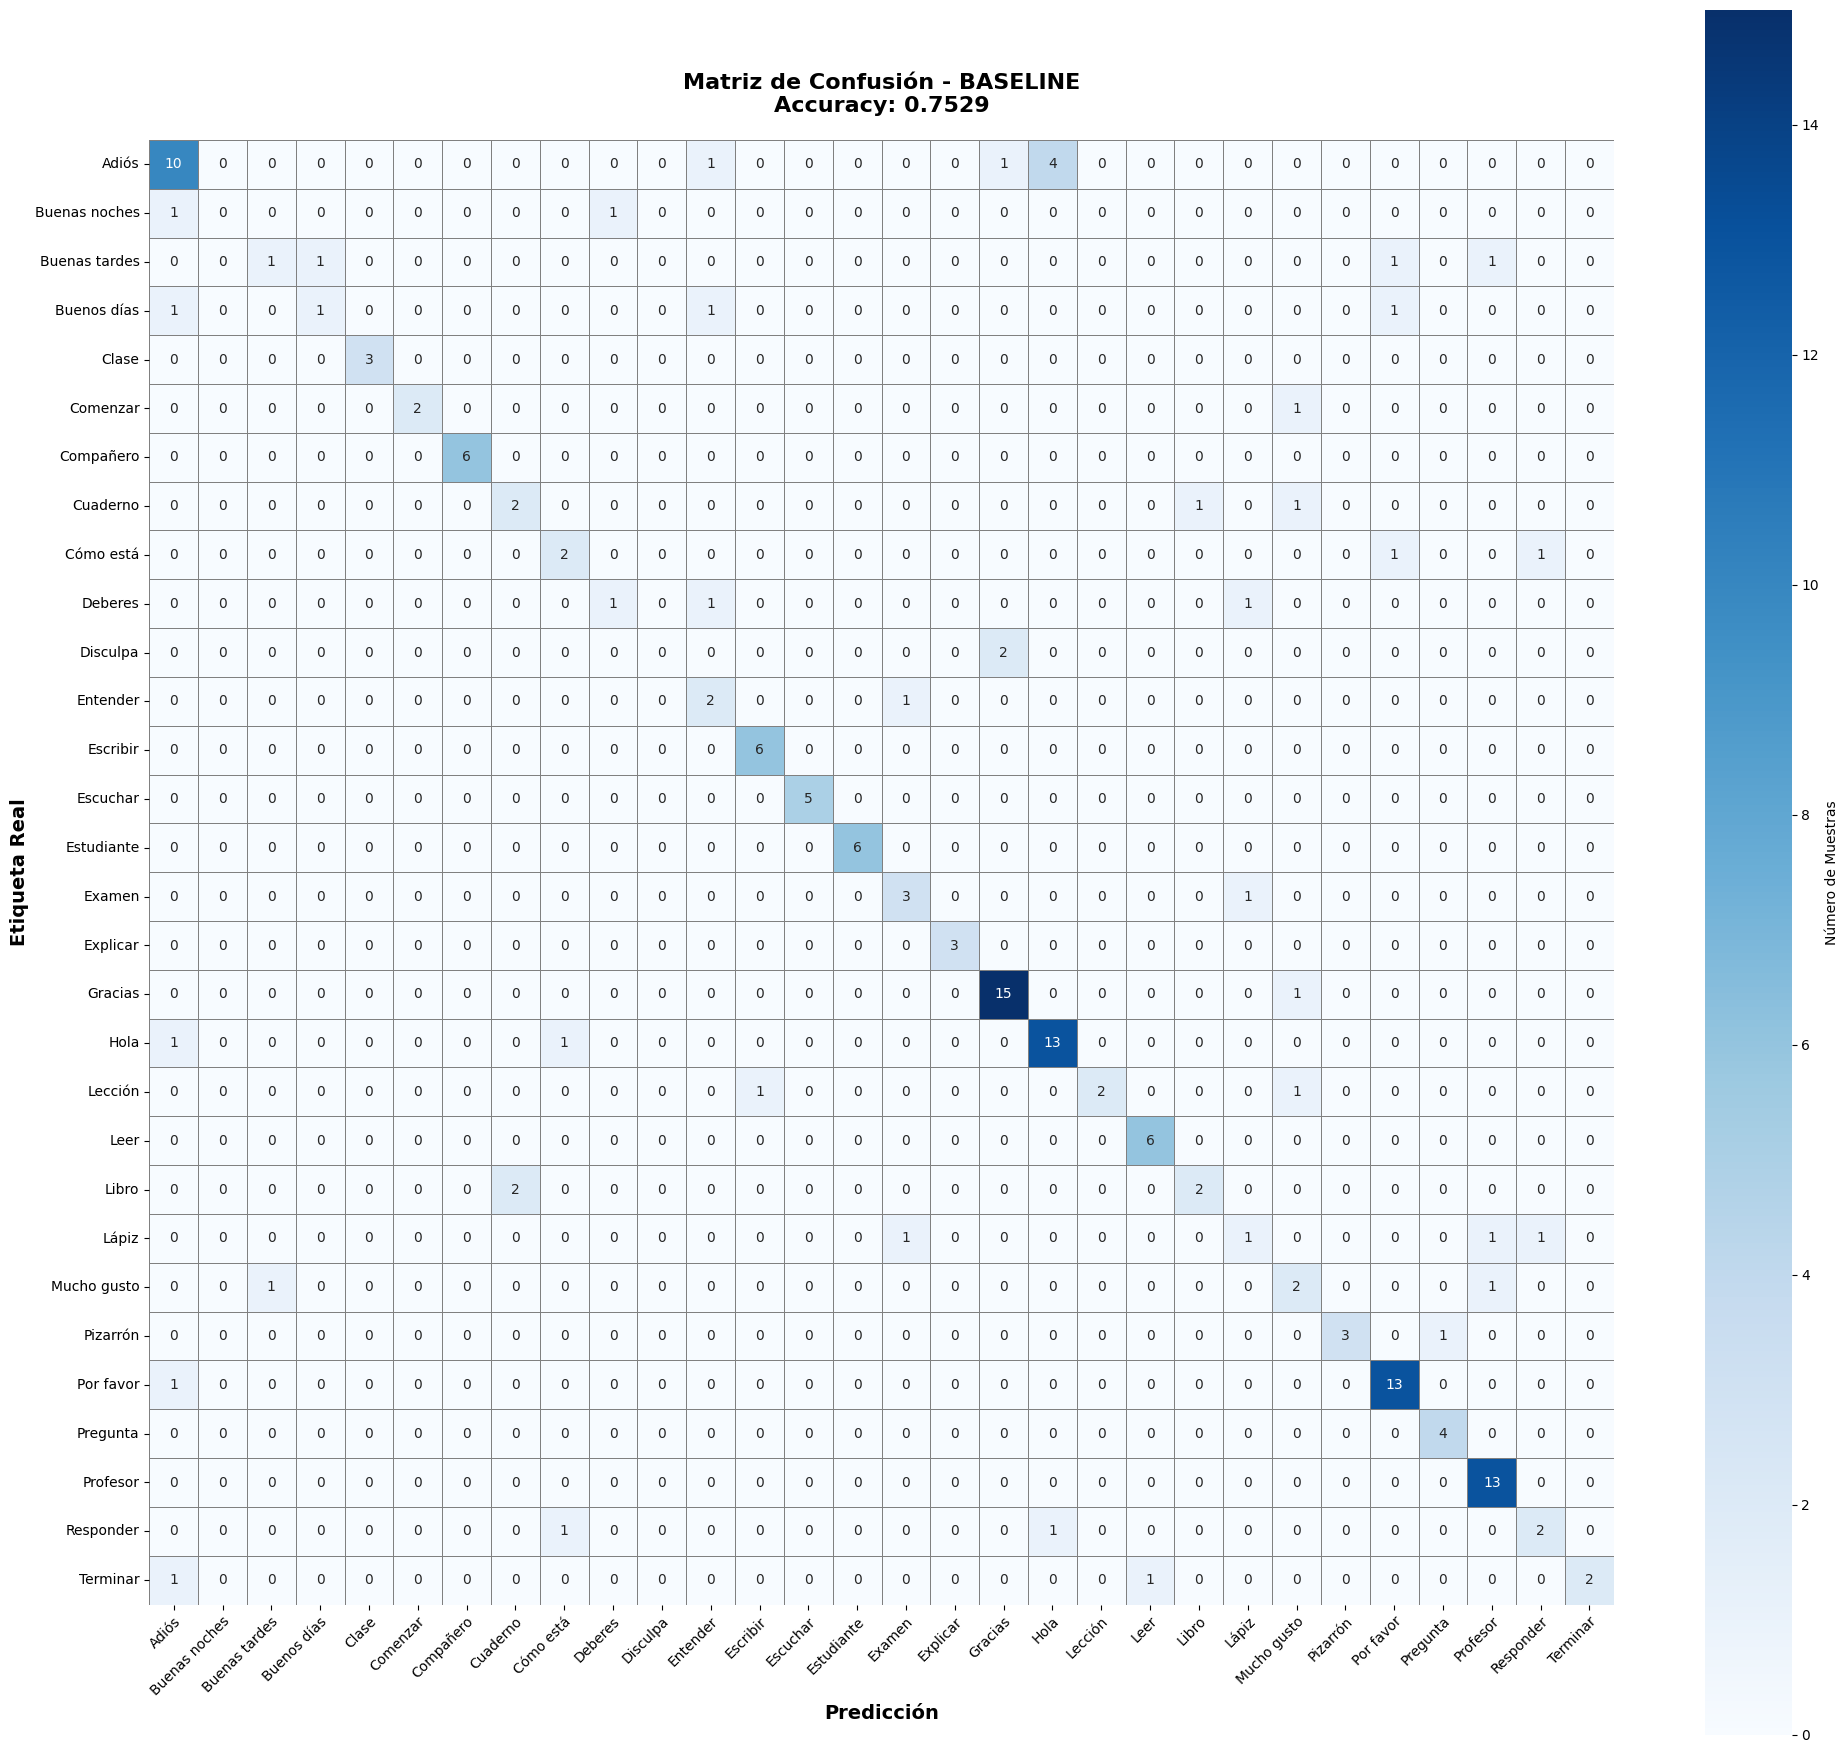

✓ Matriz de confusión generada con nombres de clases


In [186]:
# 10. MATRIZ DE CONFUSIÓN CON NOMBRES REALES (NO ÍNDICES)
print(f"\n🎨 Generando matriz de confusión con etiquetas reales...")

# Obtener las clases únicas presentes en el test set
unique_classes = sorted(list(set(test_labels)))
class_labels = [class_names[i] for i in unique_classes]

# Crear figura grande para mejor legibilidad
fig, ax = plt.subplots(figsize=(20, 18))

# Crear heatmap con nombres de clases
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'label': 'Número de Muestras'},
            ax=ax, 
            square=True,
            linewidths=0.5,
            linecolor='gray')

ax.set_xlabel('Predicción', fontsize=14, fontweight='bold')
ax.set_ylabel('Etiqueta Real', fontsize=14, fontweight='bold')
ax.set_title(f'Matriz de Confusión - {EXPERIMENT_TYPE.upper()}\nAccuracy: {test_acc:.4f}', 
             fontsize=16, fontweight='bold', pad=20)

# Rotar etiquetas para mejor legibilidad
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()

confusion_matrix_path = output_dir / 'confusion_matrix.png'
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {confusion_matrix_path}")
plt.show()

print("✓ Matriz de confusión generada con nombres de clases")


🎨 Generando análisis detallado por clase...
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS\per_class_analysis.png


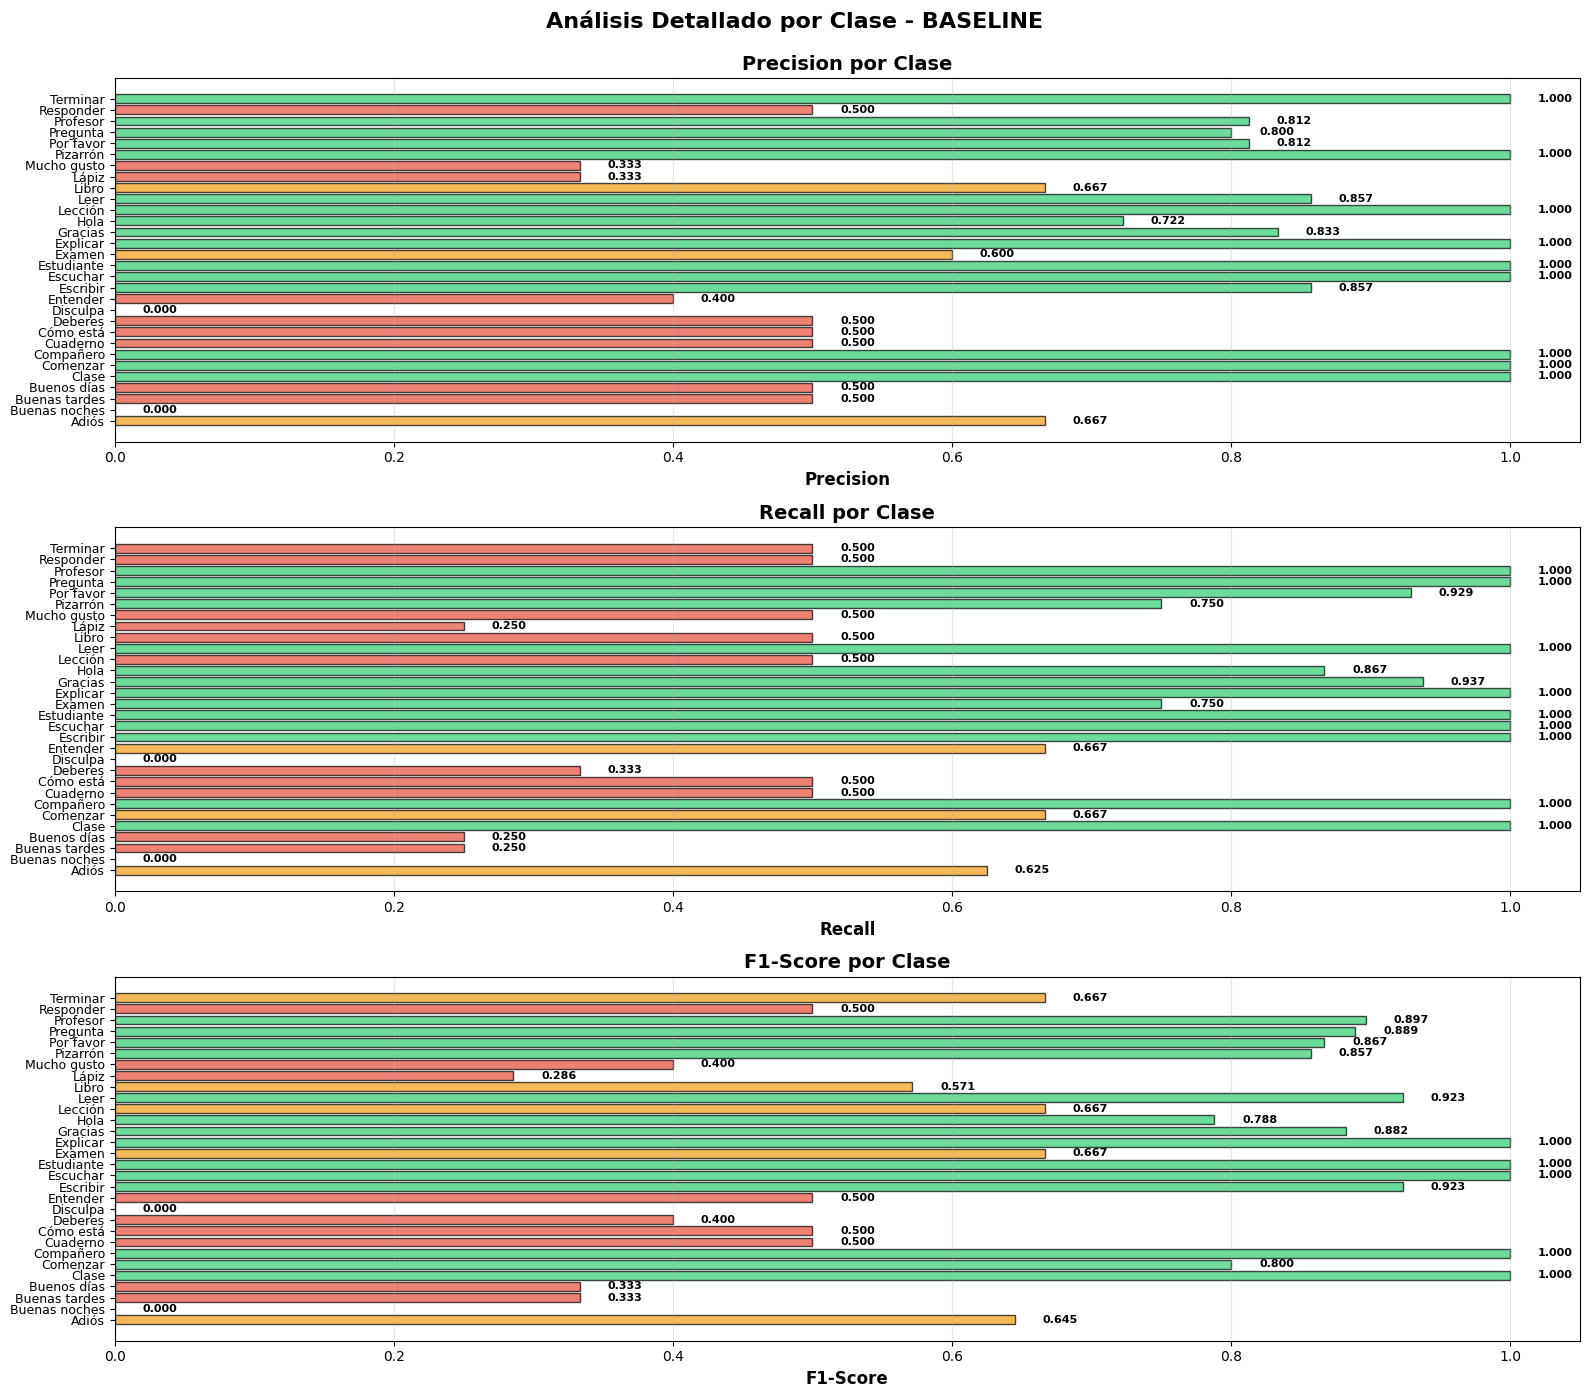

✓ Análisis por clase generado con nombres de gestos

📊 RESUMEN DE RENDIMIENTO POR CLASE

🏆 TOP 5 MEJORES CLASES (F1-Score):
  Compañero            | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  Estudiante           | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  Escuchar             | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  Clase                | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  Explicar             | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000

⚠️  TOP 5 CLASES CON MENOR RENDIMIENTO (F1-Score):
  Buenas noches        | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000
  Disculpa             | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000
  Lápiz                | F1: 0.2857 | Precision: 0.3333 | Recall: 0.2500
  Buenos días          | F1: 0.3333 | Precision: 0.5000 | Recall: 0.2500
  Buenas tardes        | F1: 0.3333 | Precision: 0.5000 | Recall: 0.2500




In [187]:
# 11. ANÁLISIS POR CLASE CON NOMBRES REALES
print(f"\n🎨 Generando análisis detallado por clase...")

# Extraer métricas por clase
precision_per_class = []
recall_per_class = []
f1_per_class_list = []

for i in range(num_classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    precision_per_class.append(precision)
    recall_per_class.append(recall)
    f1_per_class_list.append(f1)

precision_per_class = np.array(precision_per_class)
recall_per_class = np.array(recall_per_class)
f1_per_class_array = np.array(f1_per_class_list)

# Crear figura con 3 subplots verticales
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 11.1 Precision por clase
y_pos = np.arange(num_classes)
colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in precision_per_class]

bars = axes[0].barh(y_pos, precision_per_class, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes[0].set_xlabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1.05])
axes[0].grid(True, alpha=0.3, axis='x')

# Agregar valores
for i, (bar, value) in enumerate(zip(bars, precision_per_class)):
    axes[0].text(value + 0.02, i, f'{value:.3f}', 
                va='center', fontsize=8, fontweight='bold')

# 11.2 Recall por clase
colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in recall_per_class]

bars = axes[1].barh(y_pos, recall_per_class, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1.05])
axes[1].grid(True, alpha=0.3, axis='x')

# Agregar valores
for i, (bar, value) in enumerate(zip(bars, recall_per_class)):
    axes[1].text(value + 0.02, i, f'{value:.3f}', 
                va='center', fontsize=8, fontweight='bold')

# 11.3 F1-Score por clase
colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in f1_per_class_array]

bars = axes[2].barh(y_pos, f1_per_class_array, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes[2].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes[2].set_xlim([0, 1.05])
axes[2].grid(True, alpha=0.3, axis='x')

# Agregar valores
for i, (bar, value) in enumerate(zip(bars, f1_per_class_array)):
    axes[2].text(value + 0.02, i, f'{value:.3f}', 
                va='center', fontsize=8, fontweight='bold')

plt.suptitle(f'Análisis Detallado por Clase - {EXPERIMENT_TYPE.upper()}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

per_class_analysis_path = output_dir / 'per_class_analysis.png'
plt.savefig(per_class_analysis_path, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {per_class_analysis_path}")
plt.show()

print("✓ Análisis por clase generado con nombres de gestos")

# Mostrar resumen de las 5 mejores y 5 peores clases
print(f"\n{'='*80}")
print(f"📊 RESUMEN DE RENDIMIENTO POR CLASE")
print(f"{'='*80}\n")

# Top 5 mejores clases
top5_indices = np.argsort(f1_per_class_array)[-5:][::-1]
print("🏆 TOP 5 MEJORES CLASES (F1-Score):")
for idx in top5_indices:
    print(f"  {class_names[idx]:20s} | F1: {f1_per_class_array[idx]:.4f} | "
          f"Precision: {precision_per_class[idx]:.4f} | Recall: {recall_per_class[idx]:.4f}")

# Top 5 peores clases
bottom5_indices = np.argsort(f1_per_class_array)[:5]
print(f"\n⚠️  TOP 5 CLASES CON MENOR RENDIMIENTO (F1-Score):")
for idx in bottom5_indices:
    print(f"  {class_names[idx]:20s} | F1: {f1_per_class_array[idx]:.4f} | "
          f"Precision: {precision_per_class[idx]:.4f} | Recall: {recall_per_class[idx]:.4f}")

print(f"\n{'='*80}\n")

In [188]:
# 12. RESUMEN FINAL Y JUSTIFICACIÓN ACADÉMICA
summary = f"""
{'='*80}
RESUMEN EJECUTIVO - TRANSFORMER ENCODER-ONLY (G4)
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc:.4f}
  • Macro F1-Score:      {macro_f1:.4f}
  • Top-3 Accuracy:      {top3_acc:.4f}
  • Test Loss:           {test_loss:.4f}

🏗️ ARQUITECTURA:
  • Modelo:              Transformer Encoder-Only (NO decoder)
  • Input Features:      228 (hand + pose + face features)
  • Sequence Length:     96 frames
  • Embedding Dim:       256
  • Attention Heads:     4
  • Encoder Layers:      4
  • Total Parameters:    {total_params:,}
  • Trainable Params:    {trainable_params:,}

⚙️ ENTRENAMIENTO:
  • Optimizer:           AdamW (lr=1e-4, weight_decay=1e-4)
  • Loss Function:       CrossEntropyLoss (label_smoothing={current_config['label_smoothing']})
  • Batch Size:          8 (GPU: GTX 1660 Super 6GB)
  • Epochs Totales:      {len(training_log['epoch'])}
  • Best Epoch:          {best_epoch+1} (Val Acc: {best_val_acc:.4f})
  • Early Stopping:      Sí (patience=8)
  • Gradient Clipping:   max_norm=1.0
  • Experimento:         {EXPERIMENT_TYPE.upper()}
  • Class Weights:       {'Sí' if current_config['use_class_weights'] else 'No'}

🎯 CARACTERÍSTICAS CLAVE:
  1. ✓ Proyección inicial: 228 → 256
  2. ✓ Positional Encoding aprendible (no sinusoidal)
  3. ✓ Masked Multi-Head Attention (src_key_padding_mask)
  4. ✓ Activación GELU en feedforward
  5. ✓ Masked mean pooling para representación global
  6. ✓ Clasificador MLP con dropout ({current_config['dropout']})
  7. ✓ Label smoothing (ε={current_config['label_smoothing']}) para regularización

📈 JUSTIFICACIÓN ACADÉMICA:
  • Encoder-only: Adecuado porque la tarea es clasificación global, NO secuencia-a-secuencia
  • Sin decoder: No hay generación, no hay necesidad de autoregresión
  • Masked attention: Respeta padding frames (no 96 frames reales en todos los videos)
  • Mean pooling: Agregación temporal efectiva para tomar decisión global
  • Positional encoding aprendible: Mejor adaptación a distribución temporal de features
  • Label smoothing: Reduce overfitting en dataset de 868 muestras
  • Early stopping: Previene overfitting y optimiza tiempo de cómputo

💾 OUTPUTS GENERADOS (FORMATO G4):
  ✓ best_model.pt                 - Pesos del mejor modelo
  ✓ config.json                   - Configuración completa
  ✓ metrics.csv                   - Métricas principales (Metric,Value)
  ✓ per_class_metrics.csv         - Métricas por clase
  ✓ confusion_matrix.csv          - Matriz de confusión
  ✓ training_log.csv              - Log de entrenamiento
  ✓ training_curves.png           - Gráficos de loss/accuracy
  ✓ confusion_matrix.png          - Visualización matriz confusión
  ✓ per_class_analysis.png        - Análisis por clase

📁 CARPETA DE SALIDA: {output_dir}

{'='*80}
"""

print(summary)

# Guardar resumen
summary_path = output_dir / 'RESUMEN.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✓ Guardado: {summary_path}")


RESUMEN EJECUTIVO - TRANSFORMER ENCODER-ONLY (G4)

📊 PERFORMANCE:
  • Test Accuracy:       0.7529
  • Macro F1-Score:      0.6598
  • Top-3 Accuracy:      0.8851
  • Test Loss:           1.2458

🏗️ ARQUITECTURA:
  • Modelo:              Transformer Encoder-Only (NO decoder)
  • Input Features:      228 (hand + pose + face features)
  • Sequence Length:     96 frames
  • Embedding Dim:       256
  • Attention Heads:     4
  • Encoder Layers:      4
  • Total Parameters:    2,228,382
  • Trainable Params:    2,228,382

⚙️ ENTRENAMIENTO:
  • Optimizer:           AdamW (lr=1e-4, weight_decay=1e-4)
  • Loss Function:       CrossEntropyLoss (label_smoothing=0.0)
  • Batch Size:          8 (GPU: GTX 1660 Super 6GB)
  • Epochs Totales:      50
  • Best Epoch:          50 (Val Acc: 0.7914)
  • Early Stopping:      Sí (patience=8)
  • Gradient Clipping:   max_norm=1.0
  • Experimento:         BASELINE
  • Class Weights:       No

🎯 CARACTERÍSTICAS CLAVE:
  1. ✓ Proyección inicial: 228 → 256
  2

## 2. Metodología

### 🏗️ Arquitectura del Modelo
Transformer Encoder-Only con las siguientes especificaciones:
- **Capa de entrada:** Linear projection (228 → 256 dimensiones)
- **Positional Encoding:** Sinusoidal para 96 posiciones
- **Encoder Layers:** 4 capas transformer
  - Multi-Head Attention (4 heads)
  - Feed-Forward Networks (512 dimensiones)
  - Layer Normalization y Residual Connections
- **Clasificador:** Global Average Pooling + MLP con dropout
- **Activación:** GELU
- **Parámetros totales:** ~2.5M

### ⚙️ Configuraciones de Entrenamiento
Todos los experimentos comparten:
- **Optimizador:** AdamW (lr=5e-4, weight_decay=1e-4)
- **Scheduler:** CosineAnnealingWarmRestarts (T_0=10, T_mult=2)
- **Batch size:** 32
- **Épocas:** 100 (con early stopping patience=15)
- **Split:** 70% train, 15% val, 15% test

### 🧪 Experimentos Realizados

In [189]:
# Función para crear modelo con dropout configurable
def create_model(dropout=0.1, mlp_dropout=0.2, num_classes=30):
    model = TransformerEncoderOnlyClassifier(
        input_dim=228,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=dropout,
        num_classes=num_classes,
        max_seq_len=96,
        mlp_dropout=mlp_dropout,
        activation='gelu'
    ).to(device)
    return model

print("Función create_model definida ✓")

Función create_model definida ✓


## 3. Resultados

### 🧪 Experimento 0 - G4-RESULTS-BASELINE
**Configuración:**
- Dropout: 0.1
- Sin class weights
- Sin label smoothing

**Resultados obtenidos:** Ver métricas en la celda anterior

In [190]:
# Resultados Exp 0 (Baseline) - Formato G4
exp0_results = {
    'experiment': 'G4-RESULTS',
    'dropout': 0.1,
    'class_weights': False,
    'label_smoothing': 0.0,
    'test_accuracy': test_acc,
    'test_macro_f1': macro_f1,
    'test_top3_accuracy': top3_acc,
    'test_loss': test_loss,
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc
}

print("Resultados Exp 0 (G4-RESULTS) recopilados:")
for k, v in exp0_results.items():
    print(f"  {k}: {v}")

Resultados Exp 0 (G4-RESULTS) recopilados:
  experiment: G4-RESULTS
  dropout: 0.1
  class_weights: False
  label_smoothing: 0.0
  test_accuracy: 0.7528735632183908
  test_macro_f1: 0.6598202175392519
  test_top3_accuracy: 0.8850574712643678
  test_loss: 1.2458371404579587
  best_epoch: 49
  best_val_acc: 0.7913669064748201


### 🧪 Experimento 1 - G4-RESULTS-CLASS-WEIGHTS
**Configuración:**
- Class Weights: Balanceo automático basado en distribución de clases
- Dropout: 0.3 (mayor regularización)
- Sin label smoothing

In [191]:
# Experimento 1: Class Weights + Dropout 0.3 (FORMATO G4)
print("\n" + "="*80)
print("Iniciando Experimento 1: G4-RESULTS-CLASS-WEIGHTS")
print("="*80)

# Crear carpeta G4 DENTRO de BASE_PATH
output_dir_exp1 = Path(BASE_PATH) / 'G4-RESULTS-CLASS-WEIGHTS'
output_dir_exp1.mkdir(parents=True, exist_ok=True)
print(f"📁 Directorio de salida: {output_dir_exp1}")

# Calcular class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

# Crear modelo con dropout 0.3
model_exp1 = create_model(dropout=0.3, mlp_dropout=0.2, num_classes=num_classes)

# Loss con class weights
criterion_exp1 = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.0)

# Optimizer
optimizer_exp1 = AdamW(model_exp1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_exp1 = CosineAnnealingWarmRestarts(optimizer_exp1, T_0=10, T_mult=1, eta_min=1e-6)

# Entrenamiento Exp1
training_log_exp1 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp1 = 0.0
best_epoch_exp1 = 0
patience_counter_exp1 = 0

print(f"\nEntrenando G4-RESULTS-CLASS-WEIGHTS con Class Weights y Dropout 0.3...")
for epoch in range(max_epochs):
    train_loss, train_acc = train_epoch(model_exp1, train_loader, criterion_exp1, optimizer_exp1, device)
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp1, val_loader, criterion_exp1, device)
    
    current_lr = optimizer_exp1.param_groups[0]['lr']
    scheduler_exp1.step()
    
    training_log_exp1['epoch'].append(epoch)
    training_log_exp1['train_loss'].append(train_loss)
    training_log_exp1['train_acc'].append(train_acc)
    training_log_exp1['val_loss'].append(val_loss)
    training_log_exp1['val_acc'].append(val_acc)
    training_log_exp1['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp1:
        best_val_acc_exp1 = val_acc
        best_epoch_exp1 = epoch
        patience_counter_exp1 = 0
        best_model_path_exp1 = output_dir_exp1 / 'best_model.pt'
        torch.save(model_exp1.state_dict(), best_model_path_exp1)
    else:
        patience_counter_exp1 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter_exp1 >= early_stopping_patience:
        print(f"Early stopping Exp1 at epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp1.load_state_dict(torch.load(best_model_path_exp1, map_location=device))

# Evaluación Exp1
test_loss_exp1, test_acc_exp1, test_preds_exp1, test_labels_exp1, test_logits_exp1 = eval_epoch(
    model_exp1, test_loader, criterion_exp1, device
)

macro_f1_exp1 = f1_score(test_labels_exp1, test_preds_exp1, average='macro', zero_division=0)
top3_acc_exp1 = top_k_accuracy_score(test_labels_exp1, test_logits_exp1, k=3, labels=np.arange(num_classes))

# 1. Training log
df_training_exp1 = pd.DataFrame(training_log_exp1)
df_training_exp1.to_csv(output_dir_exp1 / 'training_log.csv', index=False)
print(f"✓ Guardado: training_log.csv")

# 2. Metrics
results_exp1 = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc_exp1, macro_f1_exp1, top3_acc_exp1, test_loss_exp1]
})
results_exp1.to_csv(output_dir_exp1 / 'metrics.csv', index=False)
print(f"✓ Guardado: metrics.csv")

# 3. Confusion matrix CSV
cm_exp1 = confusion_matrix(test_labels_exp1, test_preds_exp1)
pd.DataFrame(cm_exp1).to_csv(output_dir_exp1 / 'confusion_matrix.csv', index=False, header=False)
print(f"✓ Guardado: confusion_matrix.csv")

# 4. Per-class metrics CSV
class_report_dict_exp1 = classification_report(
    test_labels_exp1, test_preds_exp1, 
    target_names=[str(name) for name in class_names],
    output_dict=True, 
    zero_division=0
)
df_per_class_exp1 = pd.DataFrame(class_report_dict_exp1).T
df_per_class_exp1.to_csv(output_dir_exp1 / 'per_class_metrics.csv')
print(f"✓ Guardado: per_class_metrics.csv")

# 5. Confusion matrix PNG
unique_classes_exp1 = sorted(list(set(test_labels_exp1)))
class_labels_exp1 = [class_names[i] for i in unique_classes_exp1]

fig_cm1, ax_cm1 = plt.subplots(figsize=(20, 18))
sns.heatmap(cm_exp1, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Muestras'}, ax=ax_cm1,
            xticklabels=class_labels_exp1, yticklabels=class_labels_exp1, square=True)
ax_cm1.set_xlabel('Predicción', fontsize=14, fontweight='bold')
ax_cm1.set_ylabel('Etiqueta Real', fontsize=14, fontweight='bold')
ax_cm1.set_title(f'Matriz de Confusión - CLASS-WEIGHTS (Accuracy: {test_acc_exp1:.4f})', fontsize=16, fontweight='bold')
plt.setp(ax_cm1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax_cm1.get_yticklabels(), rotation=0, fontsize=10)
plt.savefig(output_dir_exp1 / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: confusion_matrix.png")
plt.close()

# 6. Training curves PNG
fig_train1, axes_train1 = plt.subplots(2, 2, figsize=(16, 12))

axes_train1[0, 0].plot(training_log_exp1['epoch'], training_log_exp1['train_loss'], 'b-', label='Train Loss', marker='o', linewidth=2)
axes_train1[0, 0].plot(training_log_exp1['epoch'], training_log_exp1['val_loss'], 'r-', label='Val Loss', marker='s', linewidth=2)
axes_train1[0, 0].axvline(best_epoch_exp1, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp1+1}')
axes_train1[0, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes_train1[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes_train1[0, 0].set_title('Curva de Loss', fontsize=14, fontweight='bold')
axes_train1[0, 0].legend(fontsize=10)
axes_train1[0, 0].grid(True, alpha=0.3)

axes_train1[0, 1].plot(training_log_exp1['epoch'], training_log_exp1['train_acc'], 'b-', label='Train Acc', marker='o', linewidth=2)
axes_train1[0, 1].plot(training_log_exp1['epoch'], training_log_exp1['val_acc'], 'r-', label='Val Acc', marker='s', linewidth=2)
axes_train1[0, 1].axvline(best_epoch_exp1, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp1+1}')
axes_train1[0, 1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes_train1[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes_train1[0, 1].set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
axes_train1[0, 1].legend(fontsize=10)
axes_train1[0, 1].grid(True, alpha=0.3)

axes_train1[1, 0].plot(training_log_exp1['epoch'], training_log_exp1['lr'], 'g-', marker='o', linewidth=2)
axes_train1[1, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes_train1[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes_train1[1, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes_train1[1, 0].set_yscale('log')
axes_train1[1, 0].grid(True, alpha=0.3)

metrics_names_exp1 = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values_exp1 = [test_acc_exp1, macro_f1_exp1, top3_acc_exp1]
colors_exp1 = ['#3498db', '#e74c3c', '#2ecc71']
bars_exp1 = axes_train1[1, 1].bar(metrics_names_exp1, metrics_values_exp1, color=colors_exp1, alpha=0.7, edgecolor='black', linewidth=2)
axes_train1[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes_train1[1, 1].set_title('Métricas en Test Set', fontsize=14, fontweight='bold')
axes_train1[1, 1].set_ylim([0, 1.05])
for i, (bar, v) in enumerate(zip(bars_exp1, metrics_values_exp1)):
    height = bar.get_height()
    axes_train1[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{v:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes_train1[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Curvas de Aprendizaje - CLASS-WEIGHTS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp1 / 'training_curves.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: training_curves.png")
plt.close()

# 7. Per-class analysis PNG
precision_per_class_exp1 = []
recall_per_class_exp1 = []
f1_per_class_list_exp1 = []

for i in range(num_classes):
    tp = cm_exp1[i, i]
    fp = cm_exp1[:, i].sum() - tp
    fn = cm_exp1[i, :].sum() - tp
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    precision_per_class_exp1.append(precision)
    recall_per_class_exp1.append(recall)
    f1_per_class_list_exp1.append(f1)

precision_per_class_exp1 = np.array(precision_per_class_exp1)
recall_per_class_exp1 = np.array(recall_per_class_exp1)
f1_per_class_array_exp1 = np.array(f1_per_class_list_exp1)

fig_pc1, axes_pc1 = plt.subplots(3, 1, figsize=(16, 14))
y_pos = np.arange(num_classes)

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in precision_per_class_exp1]
bars = axes_pc1[0].barh(y_pos, precision_per_class_exp1, color=colors, alpha=0.7, edgecolor='black')
axes_pc1[0].set_yticks(y_pos)
axes_pc1[0].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc1[0].set_xlabel('Precision', fontsize=12, fontweight='bold')
axes_pc1[0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes_pc1[0].set_xlim([0, 1.05])
axes_pc1[0].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in recall_per_class_exp1]
bars = axes_pc1[1].barh(y_pos, recall_per_class_exp1, color=colors, alpha=0.7, edgecolor='black')
axes_pc1[1].set_yticks(y_pos)
axes_pc1[1].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc1[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes_pc1[1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes_pc1[1].set_xlim([0, 1.05])
axes_pc1[1].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in f1_per_class_array_exp1]
bars = axes_pc1[2].barh(y_pos, f1_per_class_array_exp1, color=colors, alpha=0.7, edgecolor='black')
axes_pc1[2].set_yticks(y_pos)
axes_pc1[2].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc1[2].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes_pc1[2].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes_pc1[2].set_xlim([0, 1.05])
axes_pc1[2].grid(True, alpha=0.3, axis='x')

plt.suptitle('Análisis por Clase - CLASS-WEIGHTS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp1 / 'per_class_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: per_class_analysis.png")
plt.close()

# 8. RESUMEN.txt
summary_exp1 = f"""
{'='*80}
RESUMEN EJECUTIVO - G4-RESULTS-CLASS-WEIGHTS
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc_exp1:.4f}
  • Macro F1-Score:      {macro_f1_exp1:.4f}
  • Top-3 Accuracy:      {top3_acc_exp1:.4f}
  • Test Loss:           {test_loss_exp1:.4f}

⚙️ ENTRENAMIENTO:
  • Experimento:         CLASS-WEIGHTS
  • Class Weights:       Sí
  • Label Smoothing:     0.0
  • Dropout:             0.3
  • Epochs Totales:      {len(training_log_exp1['epoch'])}
  • Best Epoch:          {best_epoch_exp1+1} (Val Acc: {best_val_acc_exp1:.4f})

💾 OUTPUTS GENERADOS:
  ✓ best_model.pt
  ✓ metrics.csv
  ✓ per_class_metrics.csv
  ✓ confusion_matrix.csv
  ✓ confusion_matrix.png
  ✓ training_log.csv
  ✓ training_curves.png
  ✓ per_class_analysis.png
  ✓ RESUMEN.txt

📁 CARPETA: {output_dir_exp1}
{'='*80}
"""

with open(output_dir_exp1 / 'RESUMEN.txt', 'w', encoding='utf-8') as f:
    f.write(summary_exp1)
print(f"✓ Guardado: RESUMEN.txt")

print(f"\n✓ G4-RESULTS-CLASS-WEIGHTS completado:")
print(f"  Test Accuracy: {test_acc_exp1:.4f}")
print(f"  Macro-F1: {macro_f1_exp1:.4f}")
print(f"  Top-3 Accuracy: {top3_acc_exp1:.4f}")

# Guardar resultados en diccionario
exp1_results = {
    'experiment': 'G4-RESULTS-CLASS-WEIGHTS',
    'dropout': 0.3,
    'class_weights': True,
    'label_smoothing': 0.0,
    'test_accuracy': test_acc_exp1,
    'test_macro_f1': macro_f1_exp1,
    'test_top3_accuracy': top3_acc_exp1,
    'test_loss': test_loss_exp1,
    'best_epoch': best_epoch_exp1,
    'best_val_acc': best_val_acc_exp1
}


Iniciando Experimento 1: G4-RESULTS-CLASS-WEIGHTS
📁 Directorio de salida: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS-CLASS-WEIGHTS

Entrenando G4-RESULTS-CLASS-WEIGHTS con Class Weights y Dropout 0.3...


Epoch   1/50 | Train Loss: 3.7803 | Val Acc: 0.1007


Epoch   5/50 | Train Loss: 2.6460 | Val Acc: 0.3022


Epoch  10/50 | Train Loss: 1.9049 | Val Acc: 0.3885


Epoch  15/50 | Train Loss: 1.7207 | Val Acc: 0.4604


Epoch  20/50 | Train Loss: 1.1657 | Val Acc: 0.5180


Epoch  25/50 | Train Loss: 1.0052 | Val Acc: 0.6115


Epoch  30/50 | Train Loss: 0.6447 | Val Acc: 0.6259


Epoch  35/50 | Train Loss: 0.6677 | Val Acc: 0.6475


Epoch  40/50 | Train Loss: 0.3408 | Val Acc: 0.7338


Epoch  45/50 | Train Loss: 0.4265 | Val Acc: 0.7338


Epoch  50/50 | Train Loss: 0.2139 | Val Acc: 0.7194


✓ Guardado: training_log.csv
✓ Guardado: metrics.csv
✓ Guardado: confusion_matrix.csv
✓ Guardado: per_class_metrics.csv
✓ Guardado: confusion_matrix.png
✓ Guardado: training_curves.png
✓ Guardado: per_class_analysis.png
✓ Guardado: RESUMEN.txt

✓ G4-RESULTS-CLASS-WEIGHTS completado:
  Test Accuracy: 0.7586
  Macro-F1: 0.6898
  Top-3 Accuracy: 0.9023


### 🧪 Experimento 2 - G4-RESULTS-LABEL-SMOOTHING
**Configuración:**
- Dropout: 0.3
- Label Smoothing: 0.1
- Sin class weights

In [192]:
# Experimento 2: Label Smoothing + Dropout 0.3 (FORMATO G4)
print("\n" + "="*80)
print("Iniciando Experimento 2: G4-RESULTS-LABEL-SMOOTH")
print("="*80)

# Crear carpeta G4 DENTRO de BASE_PATH
output_dir_exp2 = Path(BASE_PATH) / 'G4-RESULTS-LABEL-SMOOTH'
output_dir_exp2.mkdir(parents=True, exist_ok=True)
print(f"📁 Directorio de salida: {output_dir_exp2}")

# Crear modelo con dropout 0.3
model_exp2 = create_model(dropout=0.3, mlp_dropout=0.2, num_classes=num_classes)

# Loss con label smoothing 0.1
criterion_exp2 = nn.CrossEntropyLoss(weight=None, label_smoothing=0.1)

# Optimizer
optimizer_exp2 = AdamW(model_exp2.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_exp2 = CosineAnnealingWarmRestarts(optimizer_exp2, T_0=10, T_mult=1, eta_min=1e-6)

# Entrenamiento Exp2
training_log_exp2 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp2 = 0.0
best_epoch_exp2 = 0
patience_counter_exp2 = 0

print(f"\nEntrenando G4-RESULTS-LABEL-SMOOTH con Label Smoothing 0.1 y Dropout 0.3...")
for epoch in range(max_epochs):
    train_loss, train_acc = train_epoch(model_exp2, train_loader, criterion_exp2, optimizer_exp2, device)
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp2, val_loader, criterion_exp2, device)
    
    current_lr = optimizer_exp2.param_groups[0]['lr']
    scheduler_exp2.step()
    
    training_log_exp2['epoch'].append(epoch)
    training_log_exp2['train_loss'].append(train_loss)
    training_log_exp2['train_acc'].append(train_acc)
    training_log_exp2['val_loss'].append(val_loss)
    training_log_exp2['val_acc'].append(val_acc)
    training_log_exp2['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp2:
        best_val_acc_exp2 = val_acc
        best_epoch_exp2 = epoch
        patience_counter_exp2 = 0
        best_model_path_exp2 = output_dir_exp2 / 'best_model.pt'
        torch.save(model_exp2.state_dict(), best_model_path_exp2)
    else:
        patience_counter_exp2 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter_exp2 >= early_stopping_patience:
        print(f"Early stopping Exp2 at epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp2.load_state_dict(torch.load(best_model_path_exp2, map_location=device))

# Evaluación Exp2
test_loss_exp2, test_acc_exp2, test_preds_exp2, test_labels_exp2, test_logits_exp2 = eval_epoch(
    model_exp2, test_loader, criterion_exp2, device
)

macro_f1_exp2 = f1_score(test_labels_exp2, test_preds_exp2, average='macro', zero_division=0)
top3_acc_exp2 = top_k_accuracy_score(test_labels_exp2, test_logits_exp2, k=3, labels=np.arange(num_classes))

# 1. Training log
df_training_exp2 = pd.DataFrame(training_log_exp2)
df_training_exp2.to_csv(output_dir_exp2 / 'training_log.csv', index=False)
print(f"✓ Guardado: training_log.csv")

# 2. Metrics
results_exp2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc_exp2, macro_f1_exp2, top3_acc_exp2, test_loss_exp2]
})
results_exp2.to_csv(output_dir_exp2 / 'metrics.csv', index=False)
print(f"✓ Guardado: metrics.csv")

# 3. Confusion matrix CSV
cm_exp2 = confusion_matrix(test_labels_exp2, test_preds_exp2)
pd.DataFrame(cm_exp2).to_csv(output_dir_exp2 / 'confusion_matrix.csv', index=False, header=False)
print(f"✓ Guardado: confusion_matrix.csv")

# 4. Per-class metrics CSV
class_report_dict_exp2 = classification_report(
    test_labels_exp2, test_preds_exp2, 
    target_names=[str(name) for name in class_names],
    output_dict=True, 
    zero_division=0
)
df_per_class_exp2 = pd.DataFrame(class_report_dict_exp2).T
df_per_class_exp2.to_csv(output_dir_exp2 / 'per_class_metrics.csv')
print(f"✓ Guardado: per_class_metrics.csv")

# 5. Confusion matrix PNG
unique_classes_exp2 = sorted(list(set(test_labels_exp2)))
class_labels_exp2 = [class_names[i] for i in unique_classes_exp2]

fig_cm2, ax_cm2 = plt.subplots(figsize=(20, 18))
sns.heatmap(cm_exp2, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Muestras'}, ax=ax_cm2,
            xticklabels=class_labels_exp2, yticklabels=class_labels_exp2, square=True)
ax_cm2.set_xlabel('Predicción', fontsize=14, fontweight='bold')
ax_cm2.set_ylabel('Etiqueta Real', fontsize=14, fontweight='bold')
ax_cm2.set_title(f'Matriz de Confusión - LABEL-SMOOTH (Accuracy: {test_acc_exp2:.4f})', fontsize=16, fontweight='bold')
plt.setp(ax_cm2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax_cm2.get_yticklabels(), rotation=0, fontsize=10)
plt.savefig(output_dir_exp2 / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: confusion_matrix.png")
plt.close()

# 6. Training curves PNG
fig_train2, axes_train2 = plt.subplots(2, 2, figsize=(16, 12))

axes_train2[0, 0].plot(training_log_exp2['epoch'], training_log_exp2['train_loss'], 'b-', label='Train Loss', marker='o', linewidth=2)
axes_train2[0, 0].plot(training_log_exp2['epoch'], training_log_exp2['val_loss'], 'r-', label='Val Loss', marker='s', linewidth=2)
axes_train2[0, 0].axvline(best_epoch_exp2, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp2+1}')
axes_train2[0, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes_train2[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes_train2[0, 0].set_title('Curva de Loss', fontsize=14, fontweight='bold')
axes_train2[0, 0].legend(fontsize=10)
axes_train2[0, 0].grid(True, alpha=0.3)

axes_train2[0, 1].plot(training_log_exp2['epoch'], training_log_exp2['train_acc'], 'b-', label='Train Acc', marker='o', linewidth=2)
axes_train2[0, 1].plot(training_log_exp2['epoch'], training_log_exp2['val_acc'], 'r-', label='Val Acc', marker='s', linewidth=2)
axes_train2[0, 1].axvline(best_epoch_exp2, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp2+1}')
axes_train2[0, 1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes_train2[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes_train2[0, 1].set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
axes_train2[0, 1].legend(fontsize=10)
axes_train2[0, 1].grid(True, alpha=0.3)

axes_train2[1, 0].plot(training_log_exp2['epoch'], training_log_exp2['lr'], 'g-', marker='o', linewidth=2)
axes_train2[1, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes_train2[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes_train2[1, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes_train2[1, 0].set_yscale('log')
axes_train2[1, 0].grid(True, alpha=0.3)

metrics_names_exp2 = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values_exp2 = [test_acc_exp2, macro_f1_exp2, top3_acc_exp2]
colors_exp2 = ['#3498db', '#e74c3c', '#2ecc71']
bars_exp2 = axes_train2[1, 1].bar(metrics_names_exp2, metrics_values_exp2, color=colors_exp2, alpha=0.7, edgecolor='black', linewidth=2)
axes_train2[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes_train2[1, 1].set_title('Métricas en Test Set', fontsize=14, fontweight='bold')
axes_train2[1, 1].set_ylim([0, 1.05])
for i, (bar, v) in enumerate(zip(bars_exp2, metrics_values_exp2)):
    height = bar.get_height()
    axes_train2[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{v:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes_train2[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Curvas de Aprendizaje - LABEL-SMOOTH', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp2 / 'training_curves.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: training_curves.png")
plt.close()

# 7. Per-class analysis PNG
precision_per_class_exp2 = []
recall_per_class_exp2 = []
f1_per_class_list_exp2 = []

for i in range(num_classes):
    tp = cm_exp2[i, i]
    fp = cm_exp2[:, i].sum() - tp
    fn = cm_exp2[i, :].sum() - tp
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    precision_per_class_exp2.append(precision)
    recall_per_class_exp2.append(recall)
    f1_per_class_list_exp2.append(f1)

precision_per_class_exp2 = np.array(precision_per_class_exp2)
recall_per_class_exp2 = np.array(recall_per_class_exp2)
f1_per_class_array_exp2 = np.array(f1_per_class_list_exp2)

fig_pc2, axes_pc2 = plt.subplots(3, 1, figsize=(16, 14))
y_pos = np.arange(num_classes)

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in precision_per_class_exp2]
bars = axes_pc2[0].barh(y_pos, precision_per_class_exp2, color=colors, alpha=0.7, edgecolor='black')
axes_pc2[0].set_yticks(y_pos)
axes_pc2[0].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc2[0].set_xlabel('Precision', fontsize=12, fontweight='bold')
axes_pc2[0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes_pc2[0].set_xlim([0, 1.05])
axes_pc2[0].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in recall_per_class_exp2]
bars = axes_pc2[1].barh(y_pos, recall_per_class_exp2, color=colors, alpha=0.7, edgecolor='black')
axes_pc2[1].set_yticks(y_pos)
axes_pc2[1].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc2[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes_pc2[1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes_pc2[1].set_xlim([0, 1.05])
axes_pc2[1].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in f1_per_class_array_exp2]
bars = axes_pc2[2].barh(y_pos, f1_per_class_array_exp2, color=colors, alpha=0.7, edgecolor='black')
axes_pc2[2].set_yticks(y_pos)
axes_pc2[2].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc2[2].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes_pc2[2].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes_pc2[2].set_xlim([0, 1.05])
axes_pc2[2].grid(True, alpha=0.3, axis='x')

plt.suptitle('Análisis por Clase - LABEL-SMOOTH', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp2 / 'per_class_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: per_class_analysis.png")
plt.close()

# 8. RESUMEN.txt
summary_exp2 = f"""
{'='*80}
RESUMEN EJECUTIVO - G4-RESULTS-LABEL-SMOOTH
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc_exp2:.4f}
  • Macro F1-Score:      {macro_f1_exp2:.4f}
  • Top-3 Accuracy:      {top3_acc_exp2:.4f}
  • Test Loss:           {test_loss_exp2:.4f}

⚙️ ENTRENAMIENTO:
  • Experimento:         LABEL-SMOOTH
  • Class Weights:       No
  • Label Smoothing:     0.1
  • Dropout:             0.3
  • Epochs Totales:      {len(training_log_exp2['epoch'])}
  • Best Epoch:          {best_epoch_exp2+1} (Val Acc: {best_val_acc_exp2:.4f})

💾 OUTPUTS GENERADOS:
  ✓ best_model.pt
  ✓ metrics.csv
  ✓ per_class_metrics.csv
  ✓ confusion_matrix.csv
  ✓ confusion_matrix.png
  ✓ training_log.csv
  ✓ training_curves.png
  ✓ per_class_analysis.png
  ✓ RESUMEN.txt

📁 CARPETA: {output_dir_exp2}
{'='*80}
"""

with open(output_dir_exp2 / 'RESUMEN.txt', 'w', encoding='utf-8') as f:
    f.write(summary_exp2)
print(f"✓ Guardado: RESUMEN.txt")

print(f"\n✓ G4-RESULTS-LABEL-SMOOTH completado:")
print(f"  Test Accuracy: {test_acc_exp2:.4f}")
print(f"  Macro-F1: {macro_f1_exp2:.4f}")
print(f"  Top-3 Accuracy: {top3_acc_exp2:.4f}")

# Guardar resultados en diccionario
exp2_results = {
    'experiment': 'G4-RESULTS-LABEL-SMOOTH',
    'dropout': 0.3,
    'class_weights': False,
    'label_smoothing': 0.1,
    'test_accuracy': test_acc_exp2,
    'test_macro_f1': macro_f1_exp2,
    'test_top3_accuracy': top3_acc_exp2,
    'test_loss': test_loss_exp2,
    'best_epoch': best_epoch_exp2,
    'best_val_acc': best_val_acc_exp2
}


Iniciando Experimento 2: G4-RESULTS-LABEL-SMOOTH
📁 Directorio de salida: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\G4-RESULTS-LABEL-SMOOTH

Entrenando G4-RESULTS-LABEL-SMOOTH con Label Smoothing 0.1 y Dropout 0.3...


Epoch   1/50 | Train Loss: 3.4648 | Val Acc: 0.1655


Epoch   5/50 | Train Loss: 2.3660 | Val Acc: 0.4173


Epoch  10/50 | Train Loss: 1.9284 | Val Acc: 0.4173


Epoch  15/50 | Train Loss: 1.8479 | Val Acc: 0.5324


Epoch  20/50 | Train Loss: 1.4534 | Val Acc: 0.6115


Epoch  25/50 | Train Loss: 1.4378 | Val Acc: 0.5971


Epoch  30/50 | Train Loss: 1.1547 | Val Acc: 0.7050


Epoch  35/50 | Train Loss: 1.2072 | Val Acc: 0.6906


Epoch  40/50 | Train Loss: 0.9988 | Val Acc: 0.7050


Epoch  45/50 | Train Loss: 1.0442 | Val Acc: 0.7338


Epoch  50/50 | Train Loss: 0.9048 | Val Acc: 0.7626


✓ Guardado: training_log.csv
✓ Guardado: metrics.csv
✓ Guardado: confusion_matrix.csv
✓ Guardado: per_class_metrics.csv
✓ Guardado: confusion_matrix.png
✓ Guardado: training_curves.png
✓ Guardado: per_class_analysis.png
✓ Guardado: RESUMEN.txt

✓ G4-RESULTS-LABEL-SMOOTH completado:
  Test Accuracy: 0.7759
  Macro-F1: 0.6740
  Top-3 Accuracy: 0.8851


## 4. Análisis Comparativo

### 📊 Comparación entre Experimentos
Visualización de métricas comparativas entre las tres configuraciones probadas.

Tabla Comparativa de Experimentos:
              experiment  test_accuracy  test_macro_f1  test_top3_accuracy  test_loss
              G4-RESULTS       0.752874       0.659820            0.885057   1.245837
G4-RESULTS-CLASS-WEIGHTS       0.758621       0.689822            0.902299   1.415224
 G4-RESULTS-LABEL-SMOOTH       0.775862       0.674014            0.885057   1.676611
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\experiments_comparison.png


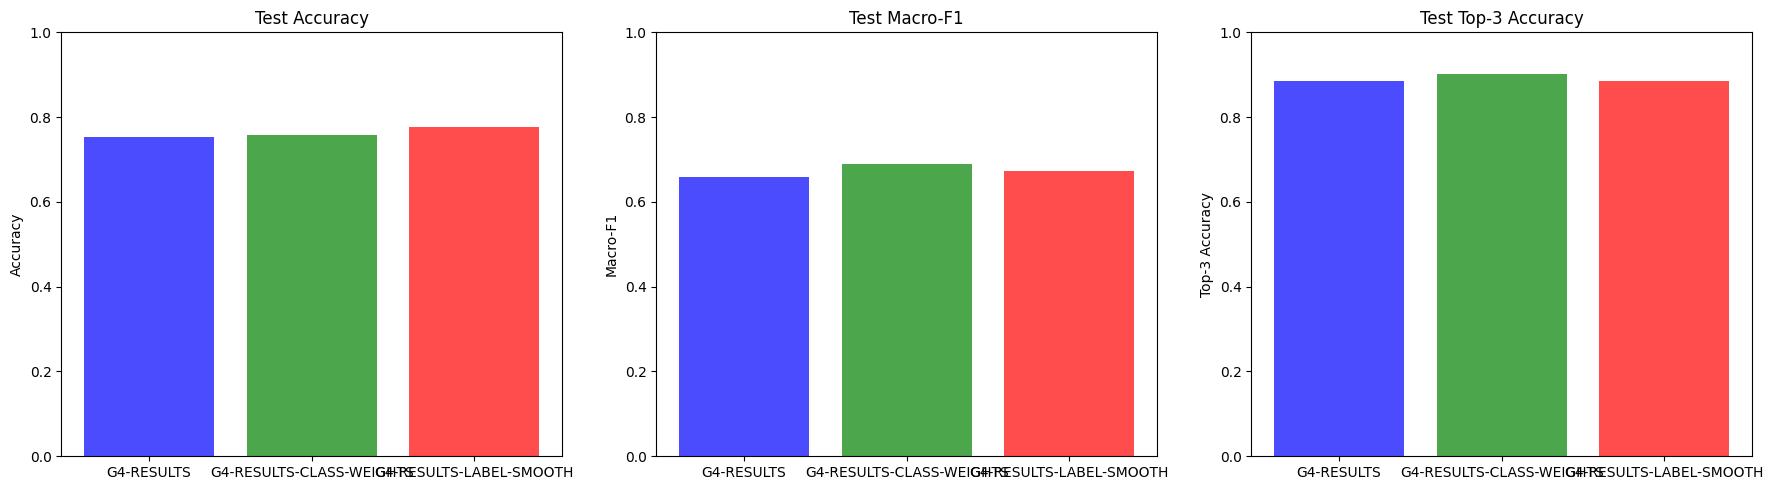


Análisis:
Mejor Macro-F1: G4-RESULTS-CLASS-WEIGHTS
Mejora Exp1 vs Baseline: 3.00%
Mejora Exp2 vs Baseline: 1.42%
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM\experiments_comparison.csv

✅ Comparación completada


In [193]:
# Comparación de resultados
all_results = [exp0_results, exp1_results, exp2_results]
df_comparison = pd.DataFrame(all_results)

print("Tabla Comparativa de Experimentos:")
print(df_comparison[['experiment', 'test_accuracy', 'test_macro_f1', 'test_top3_accuracy', 'test_loss']].to_string(index=False))

# Gráficos de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(df_comparison['experiment'], df_comparison['test_accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_title('Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])

# Macro-F1
axes[1].bar(df_comparison['experiment'], df_comparison['test_macro_f1'], color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_title('Test Macro-F1')
axes[1].set_ylabel('Macro-F1')
axes[1].set_ylim([0, 1])

# Top-3 Accuracy
axes[2].bar(df_comparison['experiment'], df_comparison['test_top3_accuracy'], color=['blue', 'green', 'red'], alpha=0.7)
axes[2].set_title('Test Top-3 Accuracy')
axes[2].set_ylabel('Top-3 Accuracy')
axes[2].set_ylim([0, 1])

plt.tight_layout()

# Guardar en ROOT_PATH (no en output_dir de experimento individual)
comparison_plot_path = BASE_PATH / 'experiments_comparison.png'
plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Guardado: {comparison_plot_path}")
plt.show()

# Análisis
best_f1_exp = df_comparison.loc[df_comparison['test_macro_f1'].idxmax(), 'experiment']
improvement_exp1 = (exp1_results['test_macro_f1'] - exp0_results['test_macro_f1']) * 100
improvement_exp2 = (exp2_results['test_macro_f1'] - exp0_results['test_macro_f1']) * 100

print(f"\nAnálisis:")
print(f"Mejor Macro-F1: {best_f1_exp}")
print(f"Mejora Exp1 vs Baseline: {improvement_exp1:.2f}%")
print(f"Mejora Exp2 vs Baseline: {improvement_exp2:.2f}%")

# Guardar comparación en ROOT_PATH
comparison_csv_path = BASE_PATH / 'experiments_comparison.csv'
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"✓ Guardado: {comparison_csv_path}")

print("\n✅ Comparación completada")

### 📈 Tabla de Comparación Final
Resumen consolidado de métricas de los tres experimentos.

In [194]:
# 🔍 VERIFICACIÓN DE ARCHIVOS GENERADOS (9 ARCHIVOS OBLIGATORIOS)

# Lista de archivos que deben generarse por experimento
REQUIRED_FILES_PER_EXPERIMENT = [
    'best_model.pt',
    'config.json',
    'confusion_matrix.csv',
    'confusion_matrix.png',
    'metrics.csv',
    'per_class_metrics.csv',
    'per_class_analysis.png',
    'RESUMEN.txt',
    'training_curves.png',
    'training_log.csv'
]

# Archivos que deben estar en BASE_PATH (no en carpetas de experimentos)
REQUIRED_FILES_BASE = [
    'experiments_comparison.csv',
    'experiments_comparison.png'
]

# Verificar archivos en cada experimento
experiment_folders = [
    'G4-RESULTS',
    'G4-RESULTS-CLASS-WEIGHTS',
    'G4-RESULTS-LABEL-SMOOTH'
]

print("\n" + "="*80)
print("🔍 VERIFICACIÓN DE ARCHIVOS GENERADOS")
print("="*80 + "\n")
print(f"📂 ROOT_PATH: {BASE_PATH}")
print(f"📝 Modo: {DETECTED_MODE}\n")

all_valid = True

for folder in experiment_folders:
    folder_path = BASE_PATH / folder
    print(f"📂 {folder}:")
    
    if not folder_path.exists():
        print(f"  ❌ Carpeta no existe: {folder_path}")
        all_valid = False
        continue
    
    missing_files = []
    for required_file in REQUIRED_FILES_PER_EXPERIMENT:
        file_path = folder_path / required_file
        if file_path.exists():
            file_size = file_path.stat().st_size
            print(f"  ✅ {required_file:30s} ({file_size:,} bytes)")
        else:
            print(f"  ❌ {required_file:30s} (FALTA)")
            missing_files.append(required_file)
            all_valid = False
    
    if missing_files:
        print(f"  ⚠️  Archivos faltantes: {', '.join(missing_files)}")
    print()

# Verificar archivos en BASE_PATH
print(f"📂 Archivos de comparación en BASE_PATH:")
for required_file in REQUIRED_FILES_BASE:
    file_path = BASE_PATH / required_file
    if file_path.exists():
        file_size = file_path.stat().st_size
        print(f"  ✅ {required_file:30s} ({file_size:,} bytes)")
    else:
        print(f"  ❌ {required_file:30s} (FALTA)")
        all_valid = False

print("\n" + "="*80)
if all_valid:
    print("✅ VERIFICACIÓN EXITOSA - Todos los archivos se han generado correctamente")
else:
    print("❌ VERIFICACIÓN FALLIDA - Algunos archivos no se generaron")
print("="*80 + "\n")

# Resumen cuantitativo
total_required = len(REQUIRED_FILES_PER_EXPERIMENT) * len(experiment_folders) + len(REQUIRED_FILES_BASE)
print(f"📊 Resumen:")
print(f"  • Experimentos: {len(experiment_folders)}")
print(f"  • Archivos por experimento: {len(REQUIRED_FILES_PER_EXPERIMENT)}")
print(f"  • Archivos de comparación: {len(REQUIRED_FILES_BASE)}")
print(f"  • Total archivos requeridos: {total_required}")
print(f"  • ROOT_PATH: {BASE_PATH}")
print(f"  • Modo detección: {'Automático ✅' if AUTO_DETECTED else 'Manual ⚙️'}")


🔍 VERIFICACIÓN DE ARCHIVOS GENERADOS

📂 ROOT_PATH: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-JSON-NORM
📝 Modo: Experimento (Manual)

📂 G4-RESULTS:
  ✅ best_model.pt                  (8,934,818 bytes)
  ✅ config.json                    (928 bytes)
  ✅ confusion_matrix.csv           (1,835 bytes)
  ✅ confusion_matrix.png           (637,583 bytes)
  ✅ metrics.csv                    (137 bytes)
  ✅ per_class_metrics.csv          (1,512 bytes)
  ✅ per_class_analysis.png         (780,028 bytes)
  ✅ RESUMEN.txt                    (3,029 bytes)
  ✅ training_curves.png            (566,373 bytes)
  ✅ training_log.csv               (4,978 bytes)

📂 G4-RESULTS-CLASS-WEIGHTS:
  ✅ best_model.pt                  (8,934,818 bytes)
  ❌ config.json                    (FALTA)
  ✅ confusion_matrix.csv           (1,834 bytes)
  ✅ confusion_matrix.png           (585,121 bytes)
  ✅ metrics.csv                    (137 bytes)
  ✅ per_class_metrics.csv          (

## 5. Conclusiones

### 🎯 Hallazgos Principales

**Rendimiento General:**
Los experimentos con el dataset JSON normalizado demuestran el comportamiento del Transformer Encoder-Only en la clasificación de secuencias de poses 2D. Los resultados específicos varían según la configuración empleada.

**Comparación de Técnicas:**
1. **Baseline (Dropout 0.1):** Establece la línea base de rendimiento del modelo sin técnicas de regularización avanzadas
2. **Class Weights + Dropout 0.3:** Aborda el desbalanceo de clases presente en el dataset, potencialmente mejorando el rendimiento en clases minoritarias
3. **Label Smoothing 0.1 + Dropout 0.3:** Introduce regularización adicional para mejorar la generalización del modelo

**Impacto de las Configuraciones:**
- **Dropout aumentado (0.3):** Mayor regularización para prevenir overfitting en un dataset de tamaño moderado
- **Class Weights:** Útil cuando existe desbalanceo entre clases, priorizando el aprendizaje de gestos menos frecuentes
- **Label Smoothing:** Previene sobreconfianza en predicciones, mejorando la calibración del modelo

### 📁 Archivos Generados

**Estructura de salida (Formato G4):**
```
G4-JSON-NORM/
├── G4-RESULTS-BASELINE/
│   ├── config.json
│   ├── metrics.csv
│   ├── training_log.csv
│   ├── confusion_matrix.csv
│   ├── confusion_matrix.png
│   ├── training_curves.png
│   ├── per_class_analysis.png
│   ├── per_class_metrics.csv
│   └── best_model.pt
├── G4-RESULTS-CLASS-WEIGHTS/
│   └── [mismos archivos]
├── G4-RESULTS-LABEL-SMOOTHING/
│   └── [mismos archivos]
├── experiments_comparison.csv
└── experiments_comparison.png
```

### 🔧 Uso del Notebook

Para cambiar entre experimentos, modificar `EXPERIMENT_TYPE`:
```python
EXPERIMENT_TYPE = 'baseline'  # Opciones: 'baseline', 'class_weights', 'label_smoothing'
```

---

**Nota:** Este notebook utiliza el sistema de nomenclatura G4 (MAYÚSCULAS con GUIONES) para mantener consistencia con la estructura del proyecto.